# 0.0 Libraries

In [1]:
import pandas as pd
import inflection
import math
import calendar
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from IPython.display import Image
import datetime
from matplotlib.gridspec import GridSpec
from scipy import stats as ss
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error
from boruta import BorutaPy
from tabulate import tabulate
import xgboost as xgb

# 1.0 Data

## 1.1 Functions

In [2]:
def cramer_v(x,y):
    cm = pd.crosstab(x, y).to_numpy()
    n = cm.sum()
    r, k = cm.shape

    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr= max(0, chi2 - (k-1)*(r-1)/(n-1))
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt((chi2corr/n) / (min(kcorr-1,rcorr-1)))

def mean_absolute_percentage_error(y, yhat):
    return np.mean(np.abs((y-yhat)/y))

def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))        
    return pd.DataFrame({'Model Name': model_name,
                         'MAE': mae,
                         'MAPE': mape,
                         'RMSE': rmse
                        }, index=[0])

def cross_validation(x_training, kfold, model_name, model, verbose=False):
    mae_list = []
    mape_list = []
    rmse_list = []

    for k in reversed(range(1,kfold+1)):
        if verbose:
            print('\nKFold Number: {}'.format(k))
        #validation start and end dates
        validation_start_date = x_training['date'].max() - datetime.timedelta(days = k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta(days = (k-1)*6*7)

        #filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        #training and validation dataset
        #training
        xtraining = training.drop(['date', 'sales'], axis=1)
        ytraining = training['sales']

        #validation
        xvalidation = validation.drop(['date', 'sales'], axis=1)
        yvalidation = validation['sales']

        #model
        m = model.fit(xtraining, ytraining)

        #prediciton
        yhat= m.predict(xvalidation)

        #performance
        m_result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat))

        #storing errors
        mae_list.append(m_result['MAE'].values[0])
        mape_list.append(m_result['MAPE'].values[0])
        rmse_list.append(m_result['RMSE'].values[0])
        
    return pd.DataFrame({ 'Model Name': model_name,
                          'MAE CV':  round(np.average(mae_list),2).astype(str) + " +/- " + round(np.std(mae_list),2).astype(str),
                          'MAPE CV': round(np.average(mape_list),2).astype(str) + " +/- " + round(np.std(mape_list),2).astype(str),
                          'RMSE CV': round(np.average(rmse_list),2).astype(str) + " +/- " + round(np.std(rmse_list),2).astype(str)
                        }, index=[0])


## 1.2 Loading Data

In [3]:
#raw data
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('data/store.csv', low_memory=False)

#joinning/merge
df_store_sales = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

In [4]:
df_store_sales.sample(5)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
483647,523,4,2014-04-24,10406,1354,1,0,0,1,c,c,50.0,11.0,2013.0,0,NaN,NaN,NaN
471773,914,1,2014-05-05,12779,1423,1,1,0,0,c,c,2640.0,4.0,2011.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec"
838510,816,1,2013-06-10,5421,840,1,0,0,0,c,c,460.0,NaN,NaN,0,NaN,NaN,NaN
829039,265,2,2013-06-18,5351,531,1,1,0,0,a,a,4580.0,NaN,NaN,1,14.0,2015.0,"Jan,Apr,Jul,Oct"
271699,868,1,2014-11-24,12178,770,1,1,0,0,d,c,1360.0,8.0,2005.0,1,10.0,2014.0,"Jan,Apr,Jul,Oct"


## 1.3 Data Overview

### 1.3.1 Renaming Columns

In [5]:
df1 = df_store_sales.copy()

In [6]:
cols_old = list(df_store_sales.columns)
snakecase = lambda x: inflection.underscore(x)
#new col names
cols_new = list(map(snakecase, cols_old))
cols_new

['store',
 'day_of_week',
 'date',
 'sales',
 'customers',
 'open',
 'promo',
 'state_holiday',
 'school_holiday',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'promo_interval']

In [7]:
df1.columns = cols_new
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

### 1.3.2 Data Dimensions


In [8]:
print('# of rows: {}'.format(df1.shape[0]))
print('# of columns: {}'.format(df1.shape[1]))

# of rows: 1017209
# of columns: 18


### 1.3.3 Data Types

In [9]:
# changing Date from object to date
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

### 1.3.4 Checking NA's

In [10]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

### 1.3.5 Filling NA's thinking about the business

In [11]:
df1['competition_distance'].max()

75860.0

In [12]:
# CompetitionDistance - no competition nearby or distance is so high we can ignore it            
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)



In [13]:
# CompetitionOpenSinceMonth - no competition or we don't know the date
# I'm using the same value as the column date to fill this NA (first iteration)    
df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1 )



In [14]:
# CompetitionOpenSinceYear     
df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1 )



In [15]:
# Promo2SinceWeek - NA = stopped promo  
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)



In [16]:
# Promo2SinceYear    
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)



In [17]:
# PromoInterval - shows the months promo was active
month_map = {}
for m in range(1,13):
    month_map[m] = str(calendar.month_name[m])[0:3] 

df1['promo_interval'].fillna(0, inplace=True)
df1['month_map'] = df1['date'].dt.month.map(month_map)
df1['is_promo'] = df1.apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)
        

In [18]:
df1.sample(5).T

,744135,614287,429407,12600,463495
store,101,708,918,336,441
day_of_week,1,6,4,1,1
date,2013-09-02 00:00:00,2013-12-28 00:00:00,2014-06-12 00:00:00,2015-07-20 00:00:00,2014-05-12 00:00:00
sales,5325,4854,5290,12893,4794
customers,662,560,604,1908,618
open,1,1,1,1,1
promo,0,0,0,0,0
state_holiday,0,0,0,0,0
school_holiday,0,0,0,0,0
store_type,d,c,a,a,d


In [19]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

### 1.3.6 Checking data types after df manipulation

In [20]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [21]:
#promo2_since_week and year are floats and can be changed to int
df1['promo2_since_week'] = df1['promo2_since_week'].astype('int64')
df1['promo2_since_year'] = df1['promo2_since_year'].astype('int64')

In [22]:
#competition_since_month and year are floats and can be changed to int
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype('int64')
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype('int64')

In [23]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

### 1.3.7 Descriptive Statistics

In [24]:
#grouping columns - numerical and categorical
num_attributes = df1.select_dtypes( include=['int64', 'float64'])
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'])

#### 1.3.7.1 Numerical Attributes

In [25]:
# Central Tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion - std, min, max, range, skw, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max()-x.min())).T #range
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# concatenating dataframes
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index() #metrics

In [26]:
m.columns = ['attributes', 'min', 'max', 'range', 'neab', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,neab,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


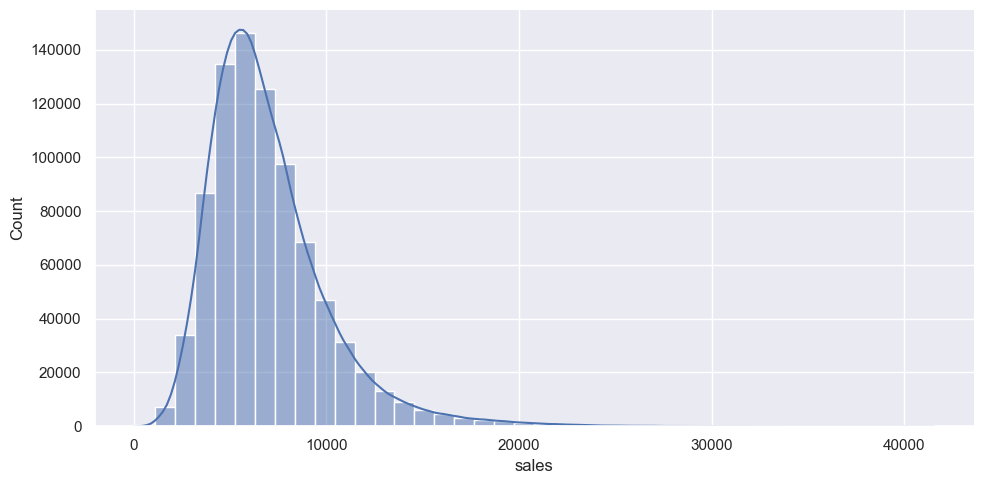

In [27]:
sns.set_theme()
df2 = df1[df1['sales']!=0]
sns.displot(df2['sales'], kde=True, height=5, aspect=2, bins=40);



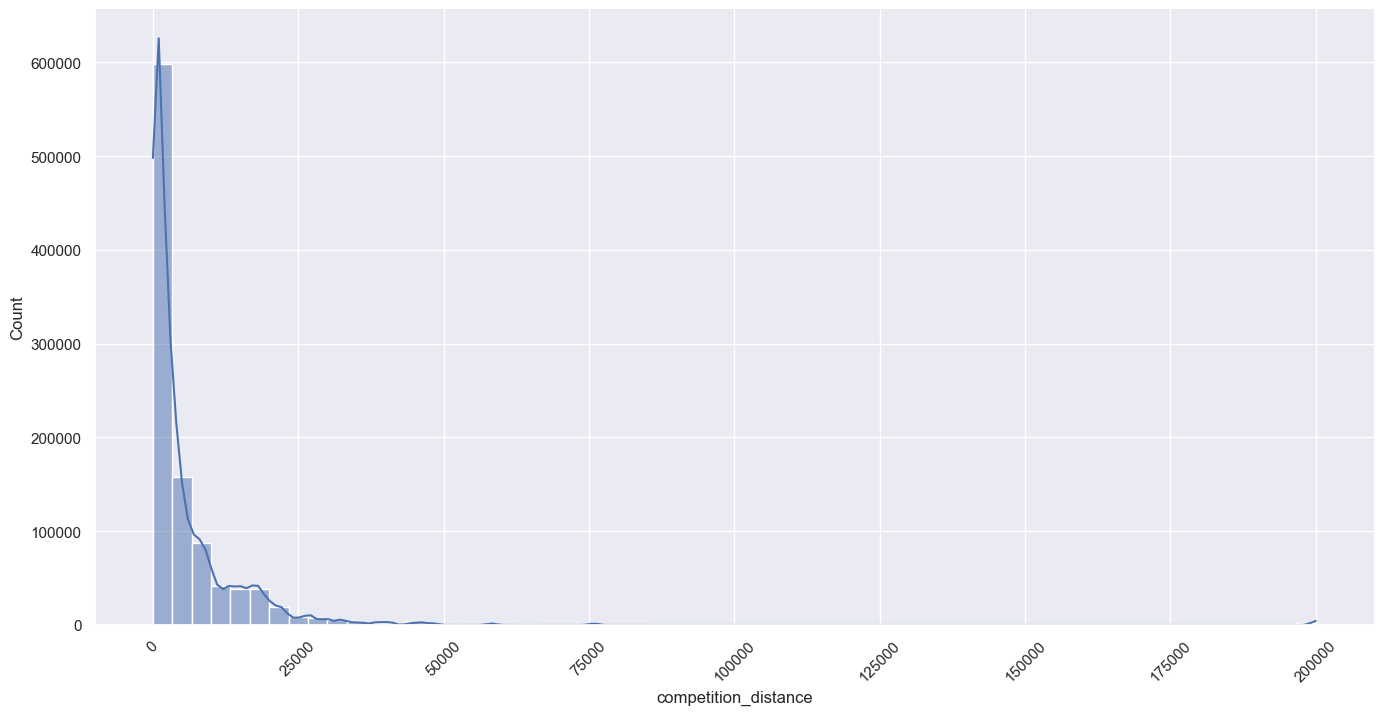

In [28]:
sns.displot(df1['competition_distance'], kde=True, bins=60, height=7, aspect=2)
plt.xticks(rotation=45);

#### 1.3.7.2 Categorical Attributes

In [29]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

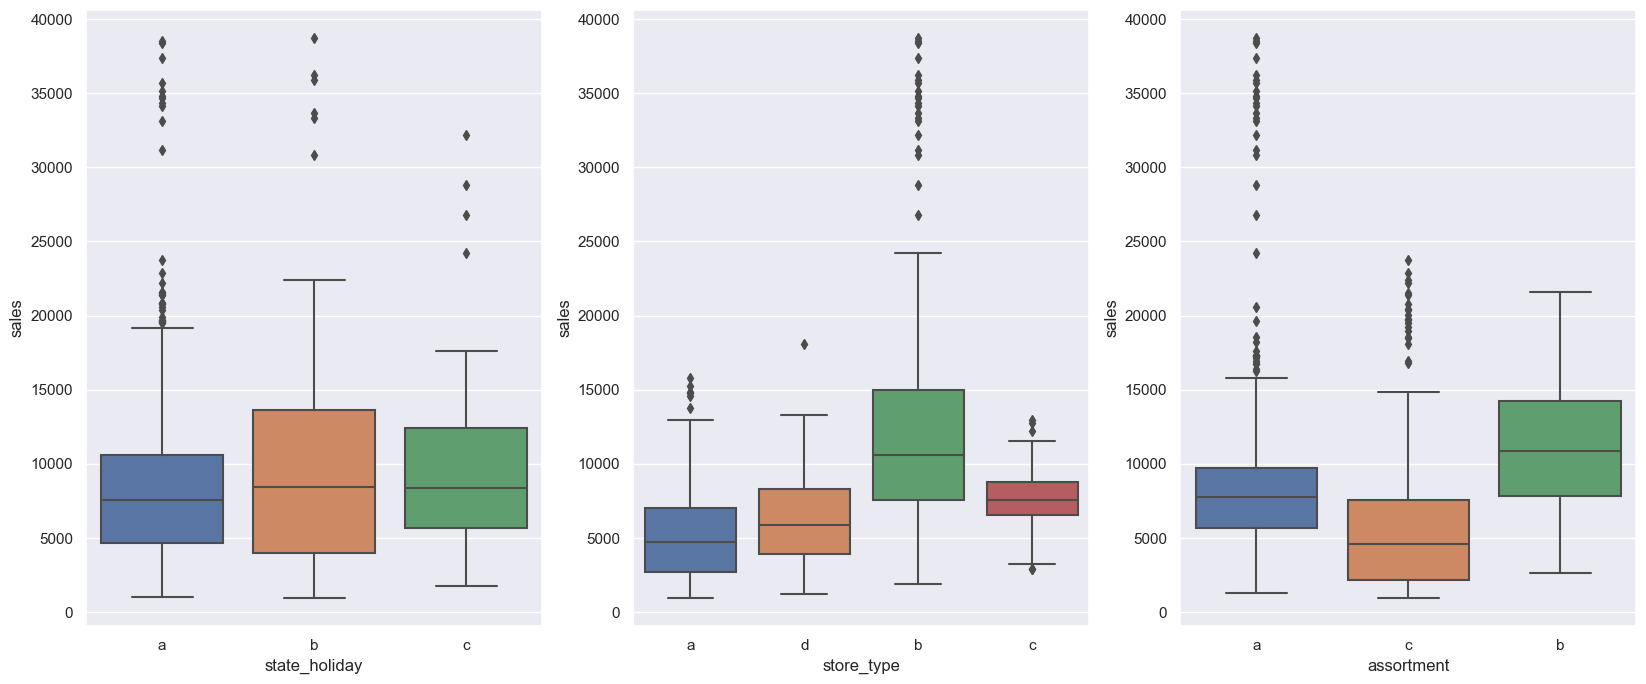

In [30]:
aux1 = df1[(df1['state_holiday']!='0') & (df1['sales']>0)]

plt.figure(figsize=(20,8))
plt.subplot(1,3,1)
sns.boxplot(aux1, x='state_holiday', y='sales')
plt.subplot(1,3,2)
sns.boxplot(aux1, x='store_type', y='sales')
plt.subplot(1,3,3)
sns.boxplot(aux1, x='assortment', y='sales');

# 2.0 Feature Engineering

In [31]:
df2 = df1.copy()

## 2.1 Hypothesis mind map

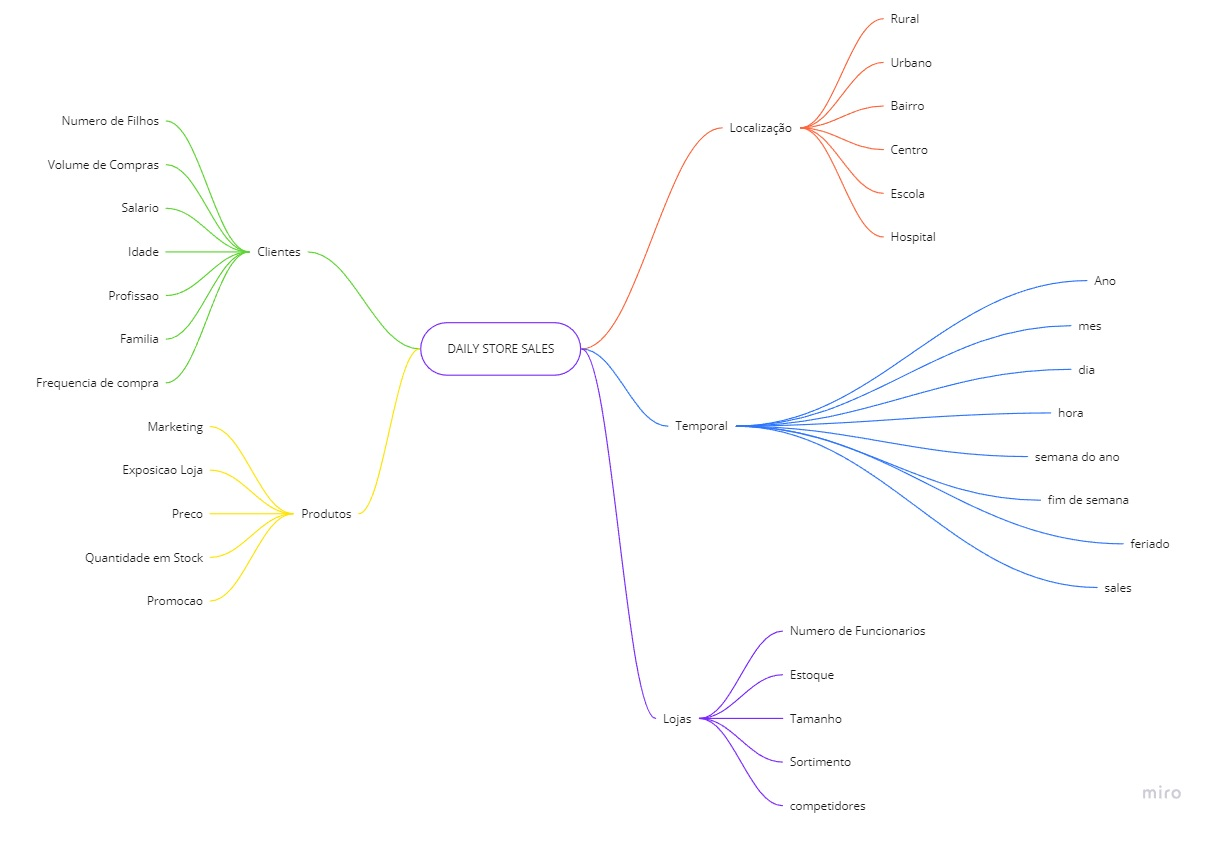

In [32]:
#mindmap coggle/miro
Image('img/mind_map.jpg')

## 2.2 Hypothesis lists

In [33]:
#hipoteses - relacionar cada atributo com a variável resposta (daily sales) para encontar uma correlação

### 2.2.1 Store Hypothesis

**1.** Lojas com maior quadro de funcionarios deveriam vender mais.\
**2.** Lojas com maior estoque deveriam vender mais.\
**3.** Lojas com maior porte deveriam vender mais.\
**4.** Lojas com maior sortimento deveriam vender mais.\
**5.** Lojas com competidores mais próximos deveriam vender menos.\
**6.** Lojas com competidores à mais tempo deveriam vender mais.

### 2.2.2 Product Hypothesis

**1.** Lojas que investem mais me marketing deveriam vender mais.\
**2.** Lojas com maior exposição dos produtos deveriam vender mais.\
**3.** Lojas que tem preços menores nos produtos deveriam vender mais.\
**4.** Lojas com promoções mais agressivas deveriam vender mais.\
**5.** Lojas com promoções ativas por mais tempo deveriam vender mais.\
**6.** Lojas com mais dias de promoção deveriam vender mais.\
**7.** Lojas com mais promoções consecutivas deveriam vender mais.\

### 2.2.3 Time Hypothesis

**1.** Lojas baertas durante o feriado de Natal deveriam vender mais.\
**2.** Lojas deveriam vender mais ao longo dos anos.\
**3.** Lojas deveriam vender mais no segundo semestre do ano.\
**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.\
**5.** Lojas deveriam vender menos aos finais de semana.\
**6.** Lojas deveriam vender menos durante os feriados escolares.

### 2.2.4 Hypothesis list

In [34]:
#priorizar as hipoteses que vão ser utilizadas na analise exploratoria
#escolher as hipoteses que já temos os dados primeiro

**1.** Lojas com maior sortimento deveriam vender mais.\
**2.** Lojas com competidores mais próximos deveriam vender menos.\
**3.** Lojas com competidores à mais tempo deveriam vender mais.\
**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.\
**5.** Lojas com mais dias de promoção deveriam vender mais.\
**6.** Lojas com mais promoções consecutivas deveriam vender mais.\
**7.** Lojas baertas durante o feriado de Natal deveriam vender mais.\
**8.** Lojas deveriam vender mais ao longo dos anos.\
**9.** Lojas deveriam vender mais no segundo semestre do ano.\
**10.** Lojas deveriam vender mais depois do dia 10 de cada mês.\
**11.** Lojas deveriam vender menos aos finais de semana.\
**12.** Lojas deveriam vender menos durante os feriados escolares.

## 2.3 Feature Engineering

In [35]:
# year
df2['year'] = df2['date'].dt.year
# month
df2['month'] = df2['date'].dt.month
# day
df2['day'] = df2['date'].dt.day
# week of year
df2['week'] = df2['date'].dt.isocalendar().week
# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

In [36]:
# competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
df2['competition_time_months'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)

In [37]:
# promo since - without month and day, join week and year to get a date
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + "-1", '%Y-%W-%w') - datetime.timedelta(days=7))
df2['promo_time_weeks'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

In [38]:
# assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

In [39]:
# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christimas' if x == 'c' else 'regular_day')

In [40]:
df2.sample(5).T

,458884,241794,843133,799159,626426
store,290,885,979,490,582
day_of_week,5,5,4,1,2
date,2014-05-16 00:00:00,2014-12-26 00:00:00,2013-06-06 00:00:00,2013-07-15 00:00:00,2013-12-17 00:00:00
sales,6091,0,5858,11112,14910
customers,627,0,659,1321,1509
open,1,0,1,1,1
promo,0,0,1,1,1
state_holiday,regular_day,christimas,regular_day,regular_day,regular_day
school_holiday,0,1,0,0,0
store_type,a,a,a,a,a


# 3.0 Filtering Variables

In [41]:
df3 = df2.copy()

In [42]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,...,is_promo,year,month,day,week,year_week,competition_since,competition_time_months,promo_since,promo_time_weeks
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,...,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 3.1 Filtering Lines

In [43]:
df3 = df3[(df3['open'] !=0) & (df3['sales'] > 0)]

## 3.2 Selecting Columns

In [44]:
#ignorar coluna customers - nós não temos o valor das próximas semanas para usar nesa predição
#para isso preciso de um projeto com predição de curtomers e utilizar o resultado com input nesse

#removendo colunas
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)

In [45]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week', 'year_week', 'competition_since',
       'competition_time_months', 'promo_since', 'promo_time_weeks'],
      dtype='object')

# 4.0 EDA - Exploratory Data Analysis

In [46]:
df4 = df3.copy()

## 4.1 Univariate Analysis

### 4.1.1 Response Variable 

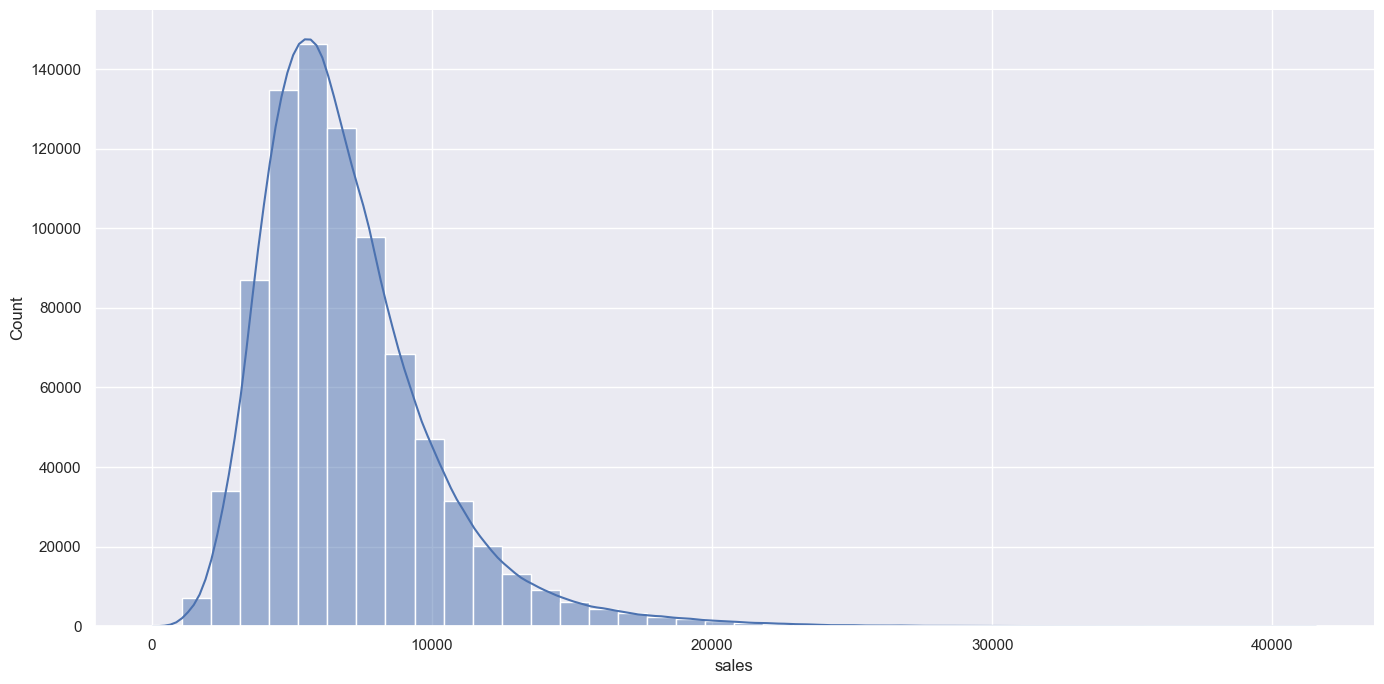

In [47]:
sns.displot(df4['sales'], bins=40, kde=True, height=7, aspect=2);

### 4.1.2 Numeric Variable 

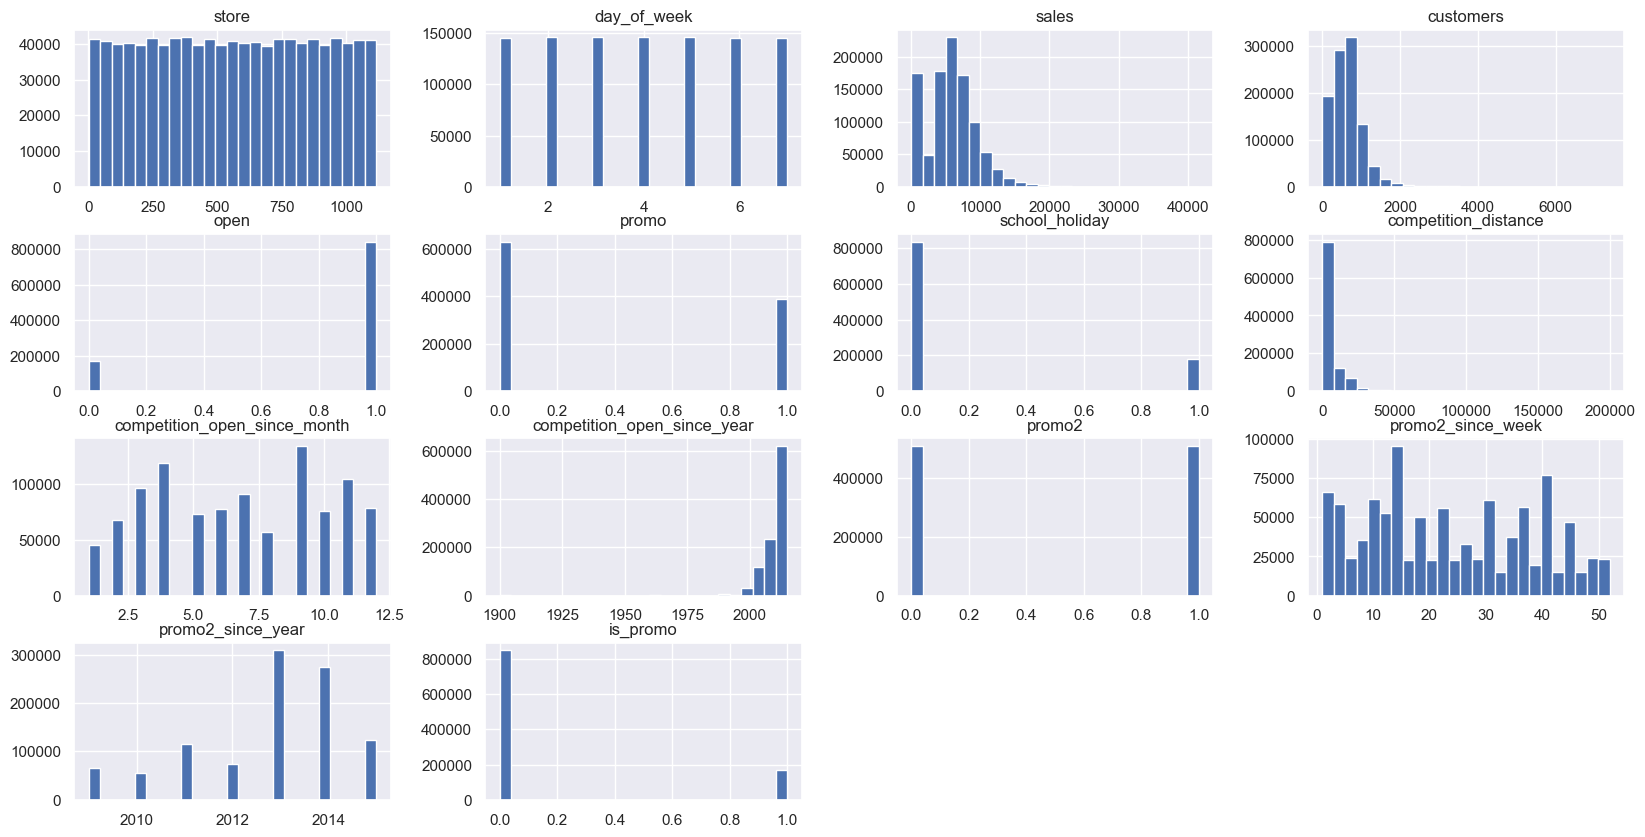

In [48]:
num_attributes.hist(bins=25, figsize=(20,10));

### 4.1.3 Categorical Variable 

In [49]:
cat_attributes.head()

,state_holiday,store_type,assortment,promo_interval,month_map
0,0,c,a,0,Jul
1,0,a,a,"Jan,Apr,Jul,Oct",Jul
2,0,a,a,"Jan,Apr,Jul,Oct",Jul
3,0,c,c,0,Jul
4,0,a,a,0,Jul


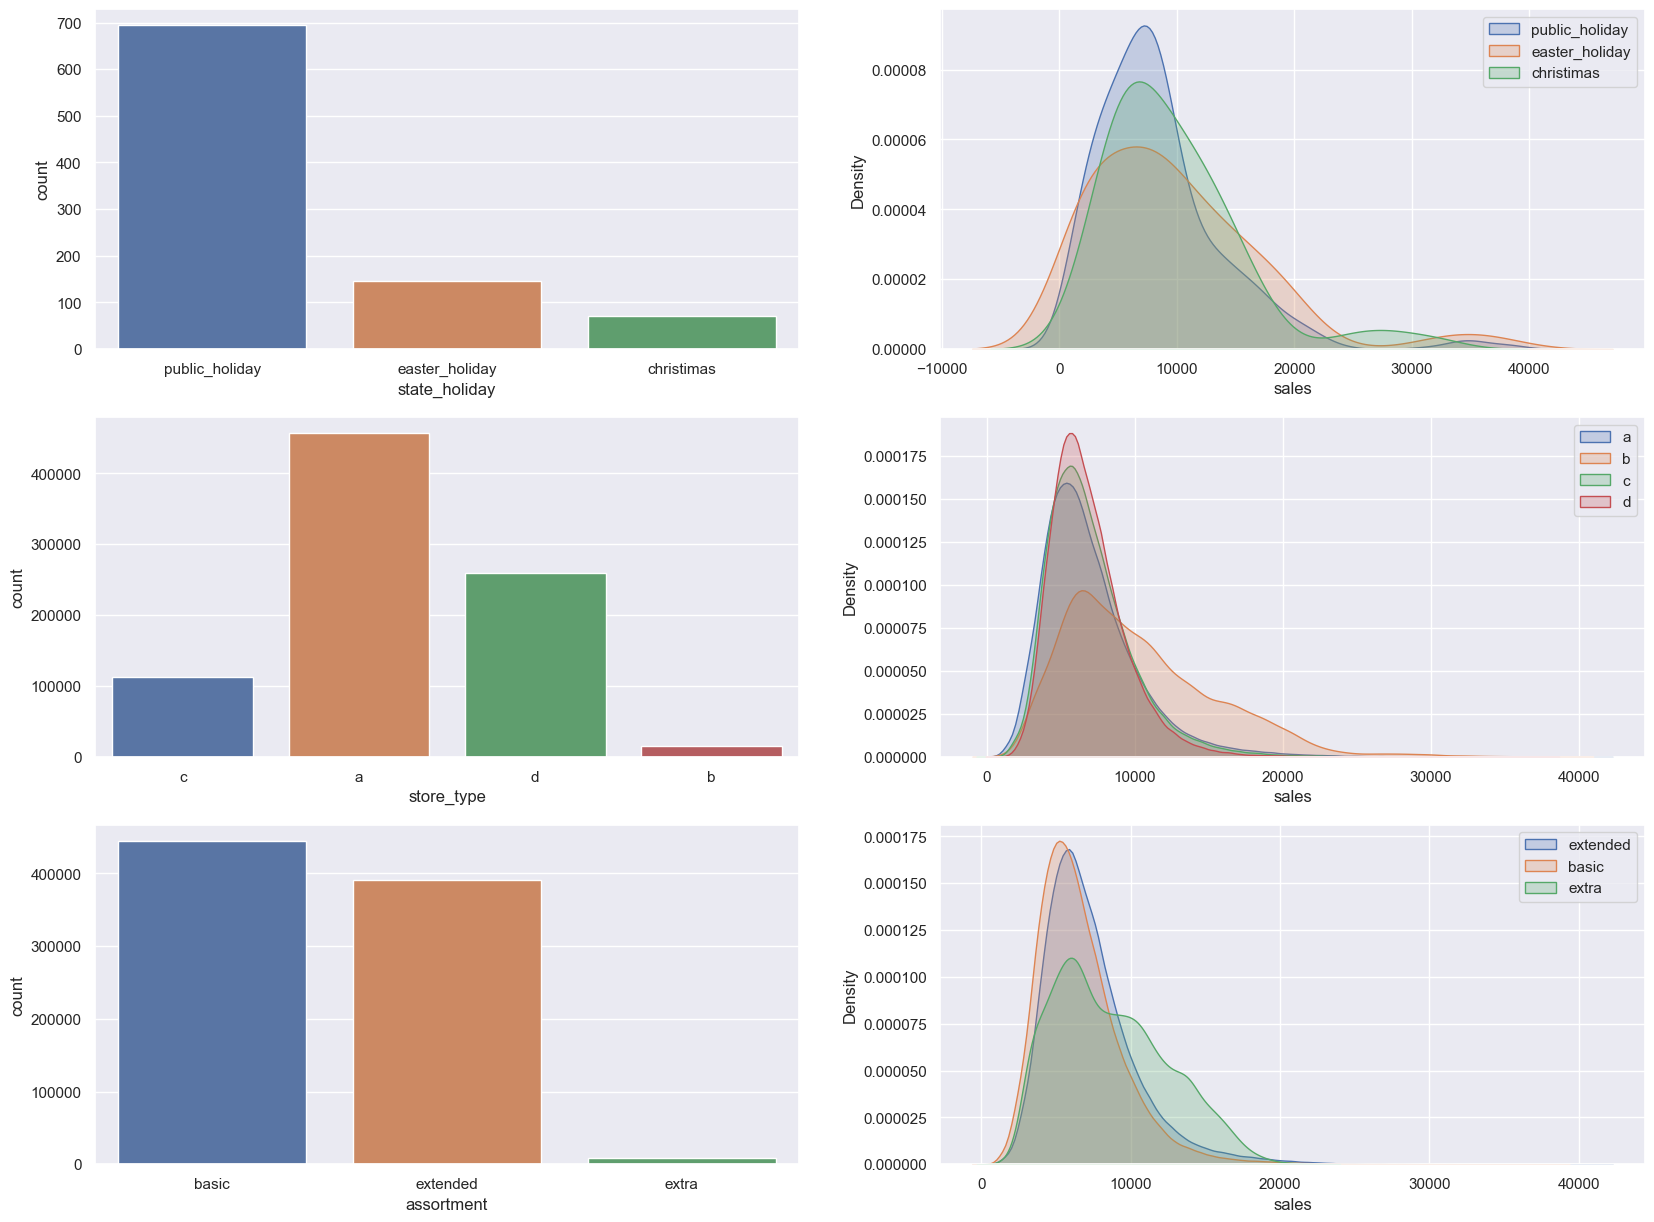

In [50]:
#state_holiday
plt.figure(figsize=(20,15))
plt.subplot(3, 2, 1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(a, x='state_holiday');

plt.subplot(3, 2, 2)
# sns.kdeplot(a, x='sales', hue='state_holiday', fill=True)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday'], x='sales', fill=True, label='public_holiday')
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday'], x='sales', fill=True, label='easter_holiday')
sns.kdeplot(df4[df4['state_holiday'] == 'christimas'], x='sales', fill=True, label='christimas')
plt.ticklabel_format(style='plain', axis='y') #remove notacao cientifica
plt.legend()

#store_type
plt.subplot(3, 2, 3)
sns.countplot(df4, x='store_type');

plt.subplot(3, 2, 4)
# sns.kdeplot(df4, x='sales', hue='store_type', hue_order=['a','b', 'c', 'd'],fill=True);
sns.kdeplot(df4[df4['store_type'] == 'a'], x='sales', fill=True, label='a')
sns.kdeplot(df4[df4['store_type'] == 'b'], x='sales', fill=True, label='b')
sns.kdeplot(df4[df4['store_type'] == 'c'], x='sales', fill=True, label='c')
sns.kdeplot(df4[df4['store_type'] == 'd'], x='sales', fill=True, label='d')
plt.legend()

#assortment
plt.subplot(3, 2, 5)
sns.countplot(df4, x='assortment');

plt.subplot(3, 2, 6)
# sns.kdeplot(df4, x='sales', hue='assortment',fill=True)
sns.kdeplot(df4[df4['assortment'] == 'extended'], x='sales', fill=True, label='extended')
sns.kdeplot(df4[df4['assortment'] == 'basic'], x='sales', fill=True, label='basic')
sns.kdeplot(df4[df4['assortment'] == 'extra'], x='sales', fill=True, label='extra')
plt.legend()

plt.show();


## 4.2 Bivariate Analysis

### 4.2.1 Hypothesis

#### **H1.** Lojas com maior sortimento deveriam vender mais.
**FAlSO** Lojas com assortment maior vendem menos 

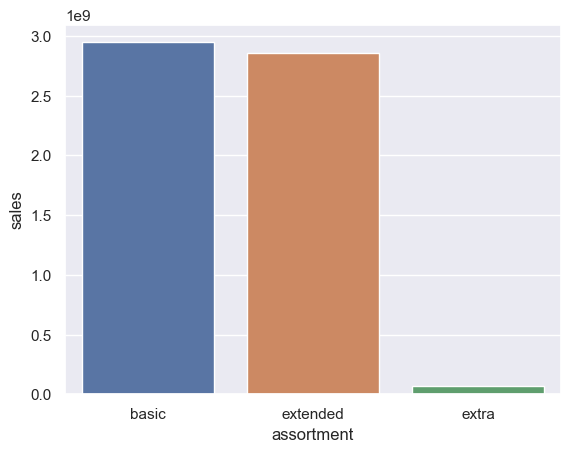

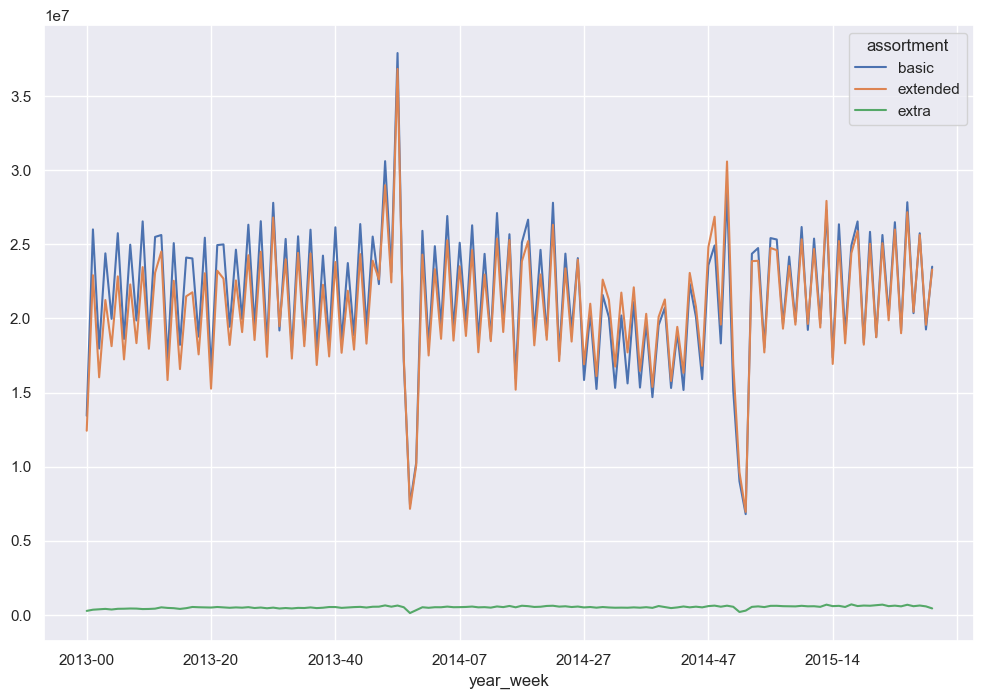

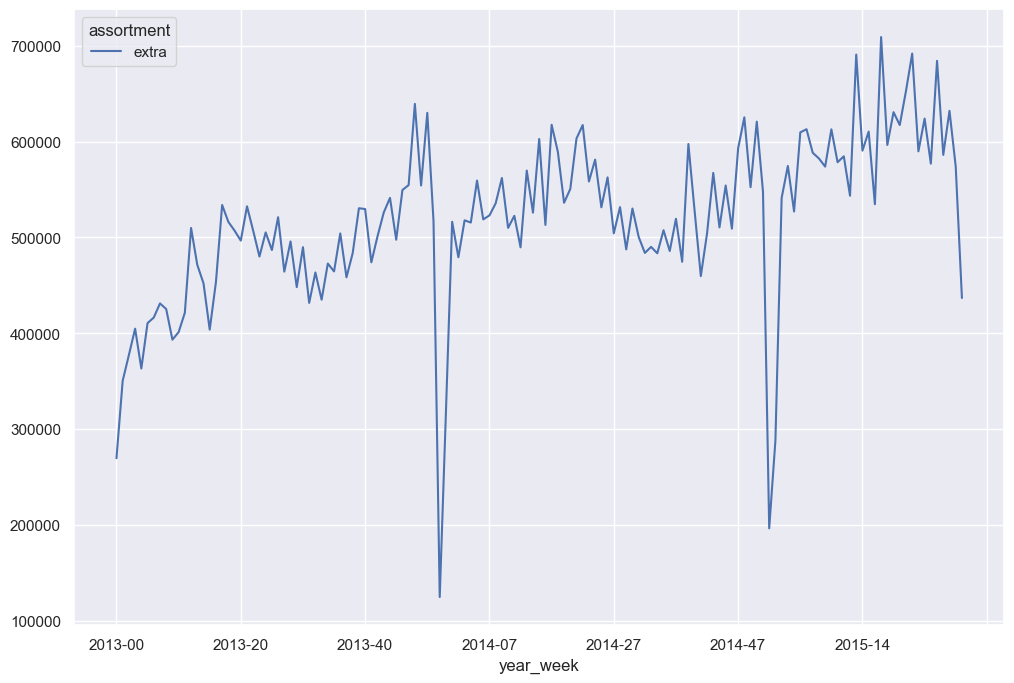

In [51]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(aux1, x='assortment', y='sales')

aux2 = df4[['year_week','assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()
aux2.pivot(index='year_week',columns='assortment',values='sales').plot(figsize=(12,8))

aux3 = aux2[aux2['assortment']=='extra']
aux3.pivot(index='year_week',columns='assortment',values='sales').plot(figsize=(12,8));

#### **H2.** Lojas com competidores mais próximos deveriam vender menos.
**FALSE** Lojas com competidores próximos vendem mais

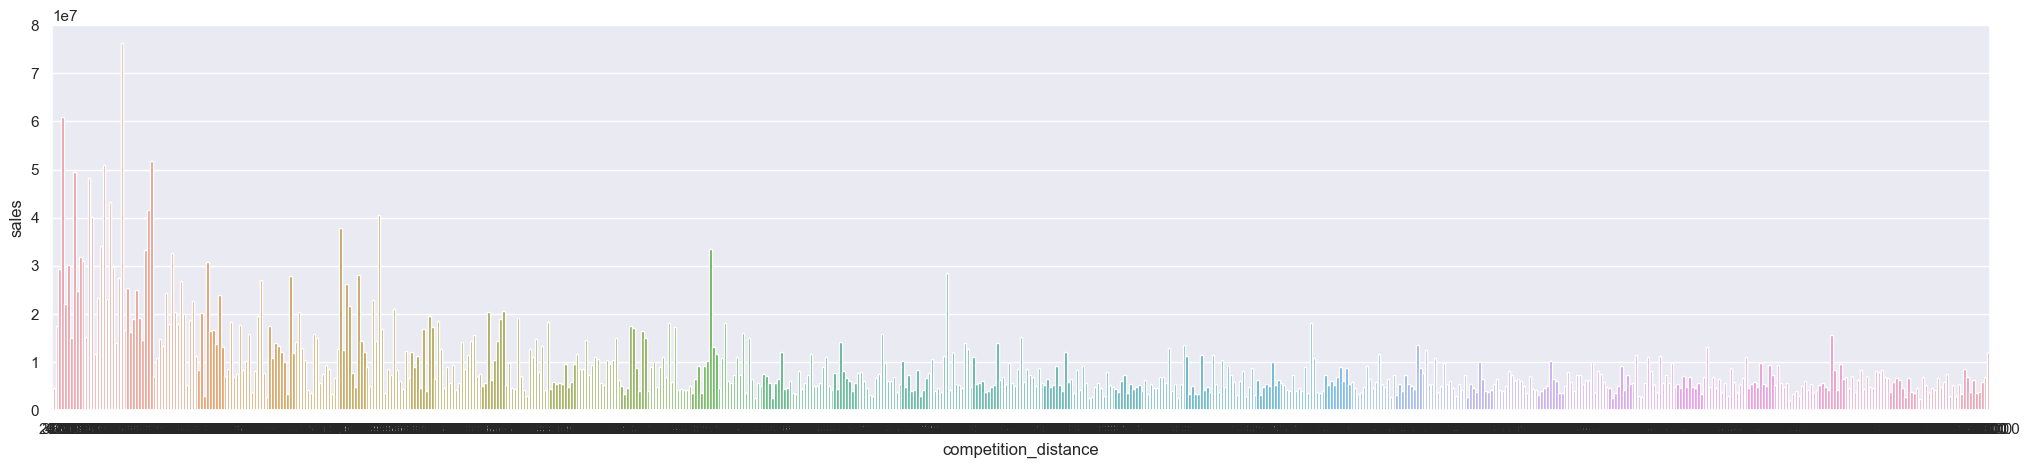

In [52]:
#figura muito granular

aux1 = df4[['competition_distance','sales']].groupby('competition_distance').sum().reset_index()
plt.figure(figsize=(25,5))
sns.barplot(aux1,x='competition_distance',y='sales');

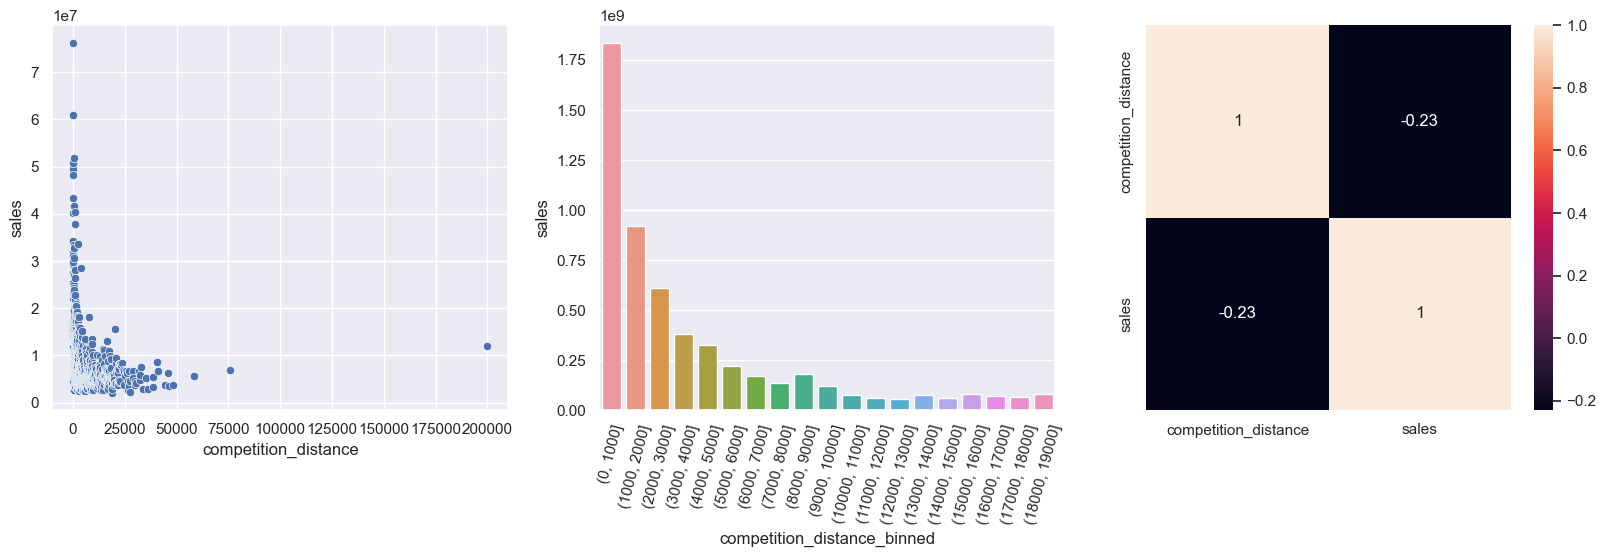

In [53]:
bins = list(np.arange(0,20000,1000))
aux1 = df4.copy()
aux1['competition_distance_binned'] = pd.cut(df4['competition_distance'], bins=bins)

plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
aux2 = aux1[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()
sns.scatterplot(aux2, x='competition_distance', y='sales')

plt.subplot(1,3,2)
aux3 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(aux3, x='competition_distance_binned',y='sales')
plt.xticks(rotation=75)

plt.subplot(1,3,3)
sns.heatmap(aux2.corr(method='pearson'), annot=True);

#### **H3.** Lojas com competidores à mais tempo deveriam vender mais.
**FALSO** Competição mais recente está relacionada com maiores vendas

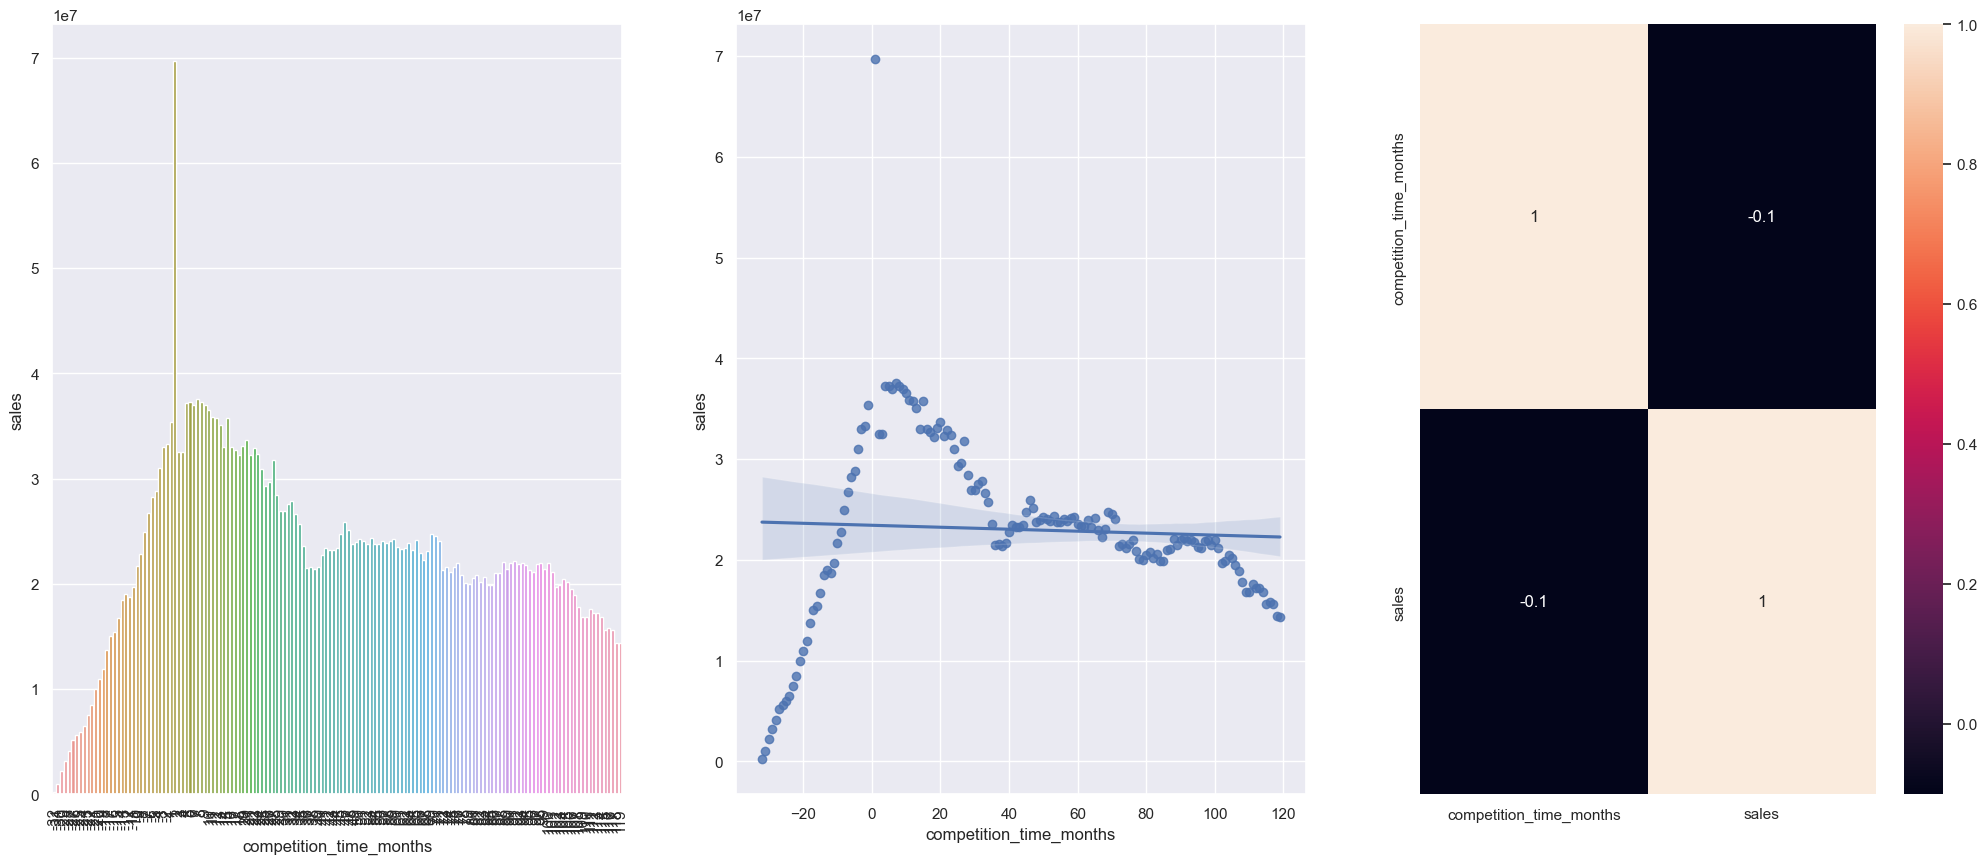

In [54]:
plt.figure(figsize=(25,10))

plt.subplot(1,3,1)
aux1 = df4[['competition_time_months', 'sales']].groupby('competition_time_months').sum().reset_index()
aux2 = aux1[(aux1['competition_time_months'] < 120) & (aux1['competition_time_months']!=0)]
sns.barplot(aux2, x='competition_time_months', y='sales')
plt.xticks(rotation=90)

plt.subplot(1,3,2)
sns.regplot(aux2, x='competition_time_months', y='sales'); # esse gráfico é apenas para demonstração e não tem significado muito forte

plt.subplot(1,3,3)
sns.heatmap(aux1.corr('pearson'), annot=True);
#valores negativos indicam daqui quanto tempo abrirá um competidor

#### **H4.** Lojas com promoções ativas por mais tempo deveriam vender mais.
**FALSO** Durante um período de tempo mais longo de promoção, as lojas passam a vender menos

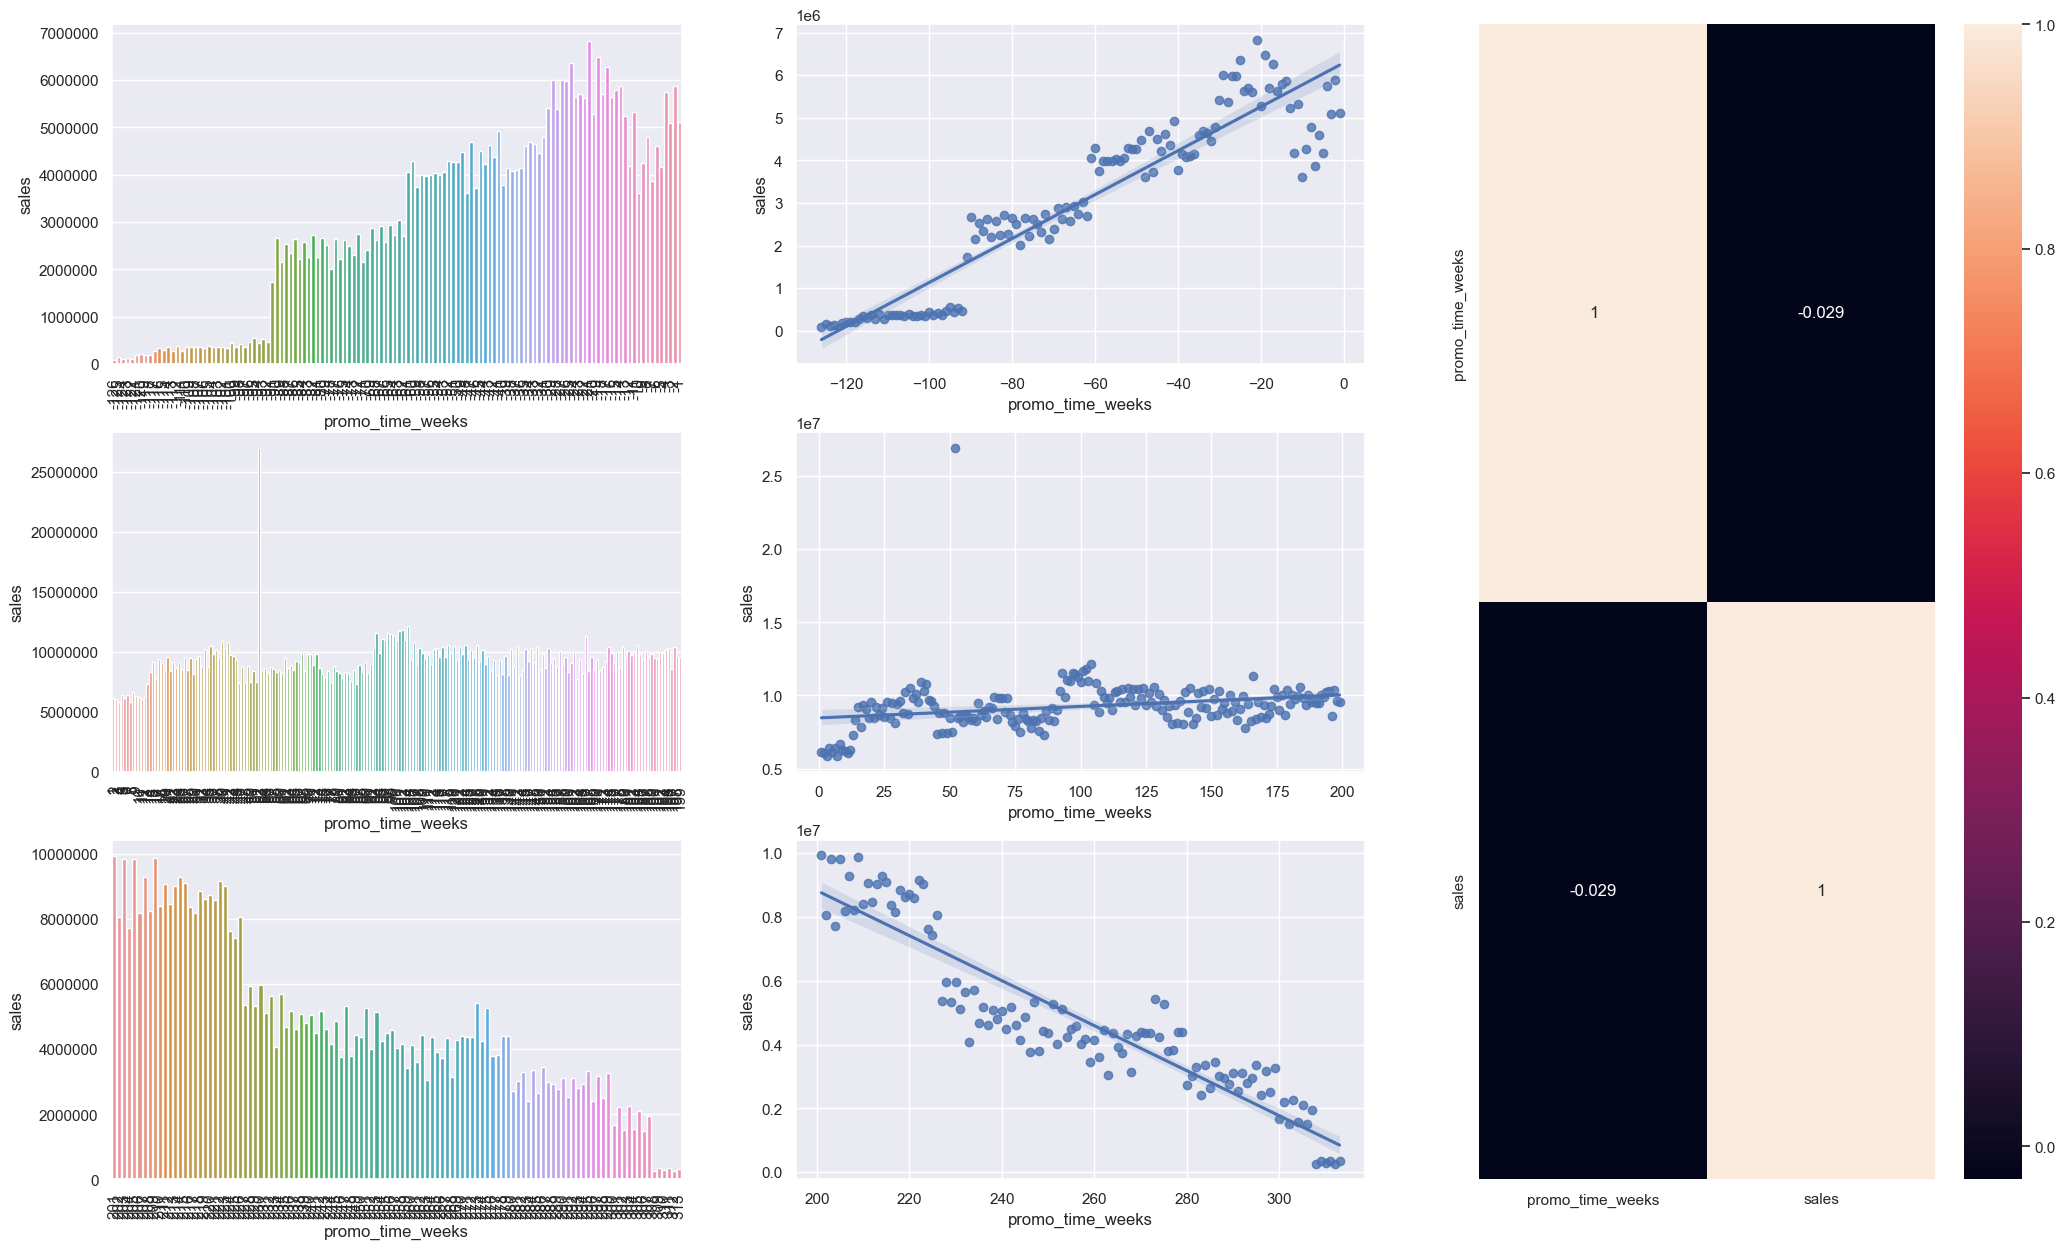

In [55]:
#promo_time_weeks < 0 -> periodo de promocao regular
#promo_time_weeks > 0 -> periodo de promocao estendido

# plt.figure(figsize=(25,15))
aux1 = df4[['promo_time_weeks','sales']].groupby('promo_time_weeks').sum().reset_index()

grid = GridSpec(3, 3)

plt.figure(figsize=(25,15))
plt.subplot(grid[0,0])
promo_regular = aux1[aux1['promo_time_weeks'] < 0]
sns.barplot(promo_regular, x='promo_time_weeks', y='sales')
plt.ticklabel_format(style='plain', axis='y')
plt.xticks(rotation=90)

plt.subplot(grid[0,1])
sns.regplot(promo_regular, x='promo_time_weeks', y='sales')

plt.subplot(grid[1,0])
promo_extended = aux1[(aux1['promo_time_weeks'] > 0) & (aux1['promo_time_weeks'] < 200)]
sns.barplot(promo_extended, x='promo_time_weeks', y='sales')
plt.ticklabel_format(style='plain', axis='y')
plt.xticks(rotation=90)

plt.subplot(grid[1,1])
sns.regplot(promo_extended, x='promo_time_weeks', y='sales')

plt.subplot(grid[2,0])
promo_extended = aux1[aux1['promo_time_weeks'] > 200]
sns.barplot(promo_extended, x='promo_time_weeks', y='sales')
plt.ticklabel_format(style='plain', axis='y')
plt.xticks(rotation=90)

plt.subplot(grid[2,1])
sns.regplot(promo_extended, x='promo_time_weeks', y='sales')

plt.subplot(grid[:,2])
sns.heatmap(aux1.corr(method='pearson'),annot=True);

#### **H5.** Lojas com mais dias de promoção deveriam vender mais.

In [56]:
#validar para dias é semelhante

#### **H6.** Lojas com mais promoções consecutivas deveriam vender mais.
**FALSO** Lojas que participaram apenas da promocao tradicional venderam mais

In [57]:
df4[['promo', 'promo2', 'sales']].groupby(['promo','promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


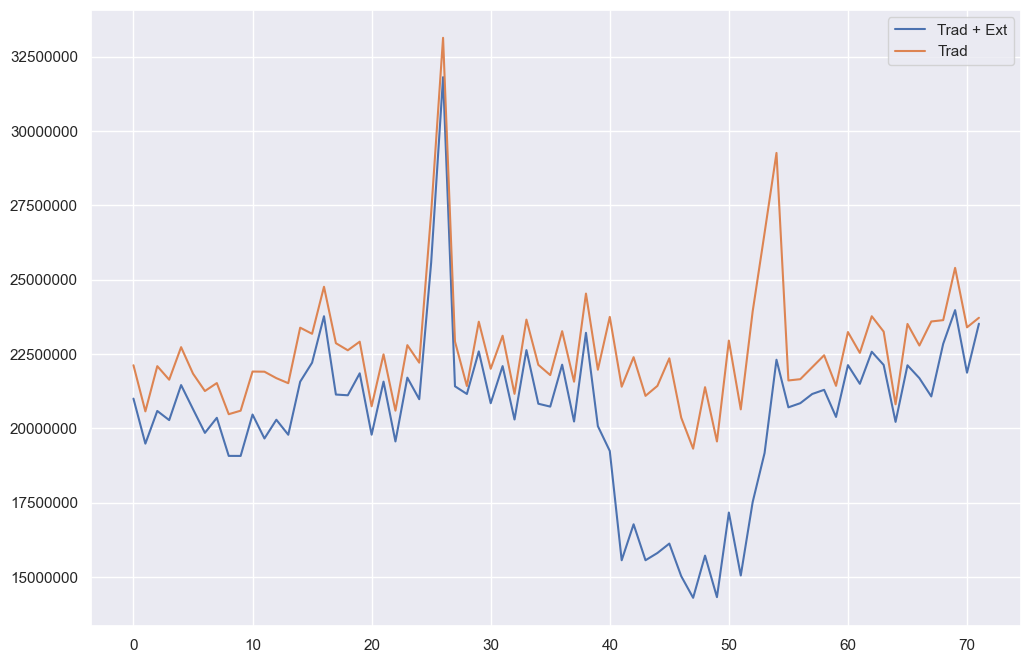

In [58]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week','sales']].groupby('year_week').sum().reset_index()
aux = aux1.plot()
# plt.ticklabel_format(style='plain', axis='y')

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week','sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=aux, figsize=(12,8))
plt.ticklabel_format(style='plain', axis='y')
aux.legend(labels=['Trad + Ext', 'Trad']);

#### **H7.** Lojas aertas durante o feriado de Natal deveriam vender mais.
**FALSO** Lojas vendem menos no feriadod e Natal. obs. o ano de 2015 não estava fechado

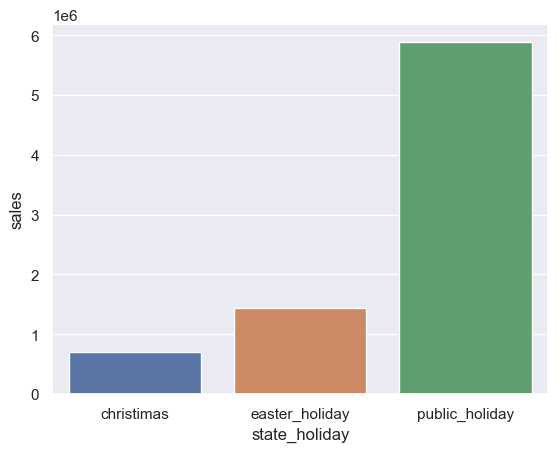

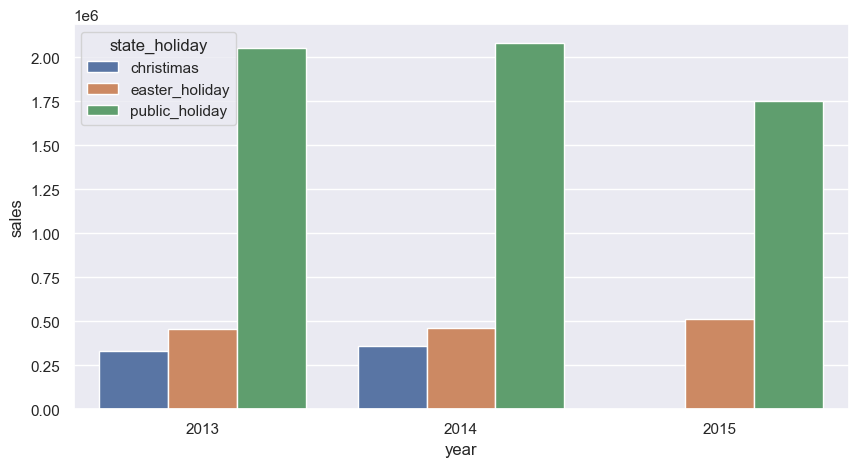

In [59]:
aux = df4[df4['state_holiday'] != 'regular_day']
aux1 = aux[['state_holiday','sales']].groupby('state_holiday').sum().reset_index()

sns.barplot(aux1, x='state_holiday', y='sales')

aux2 = aux[['year','state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()
plt.figure(figsize=(10,5))
sns.barplot(aux2, x='year', y= 'sales', hue='state_holiday');

#### **H8.** Lojas deveriam vender mais ao longo dos anos.
**FALSO** lojas estavam vendendo menos ao longo dos anos.

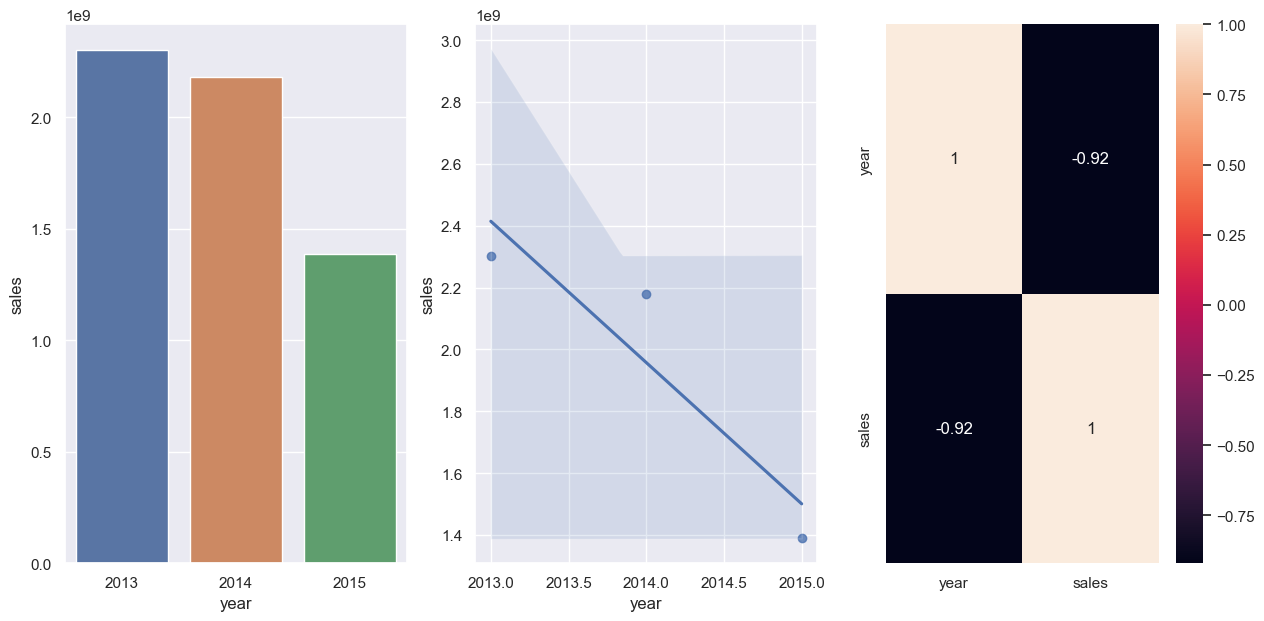

In [60]:
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()

plt.figure(figsize=(15,7))
plt.subplot(1,3,1)
sns.barplot(aux1, x='year', y='sales')

plt.subplot(1,3,2)
sns.regplot(aux1, x='year', y='sales')

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

#### **H9.** Lojas deveriam vender mais no segundo semestre do ano.
**FALSO** Lojas vendem menos no segundo semestre do ano

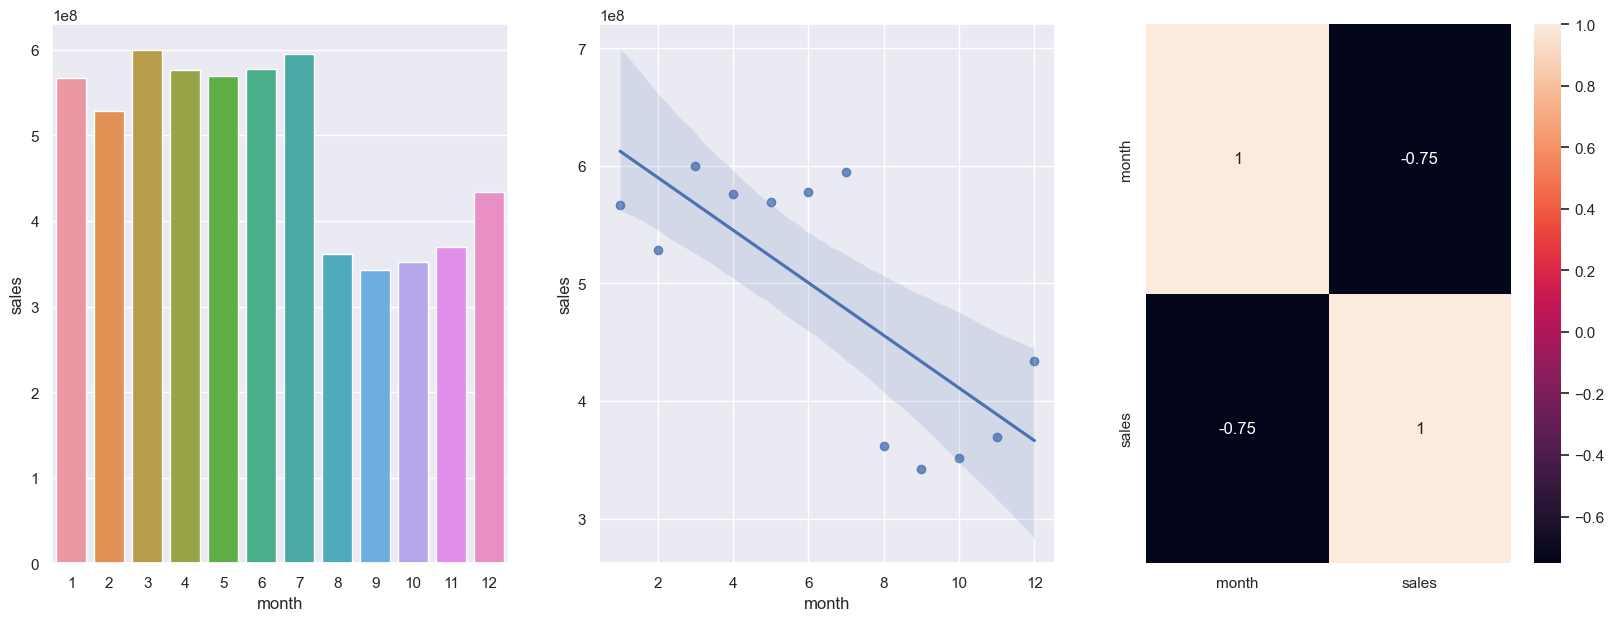

In [61]:
aux1 = df4[['month', 'sales']].groupby('month').sum().reset_index()

plt.figure(figsize=(20,7))
plt.subplot(1,3,1)
sns.barplot(aux1, x='month', y='sales')

plt.subplot(1,3,2)
sns.regplot(aux1, x='month', y='sales')

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);


#### **H10.** Lojas deveriam vender mais depois do dia 10 de cada mês.
**VERDADEIRO** Por mais que o recebimento de salário seja um fator, as pessoas compram menos nos primeiros 10 dias do mes

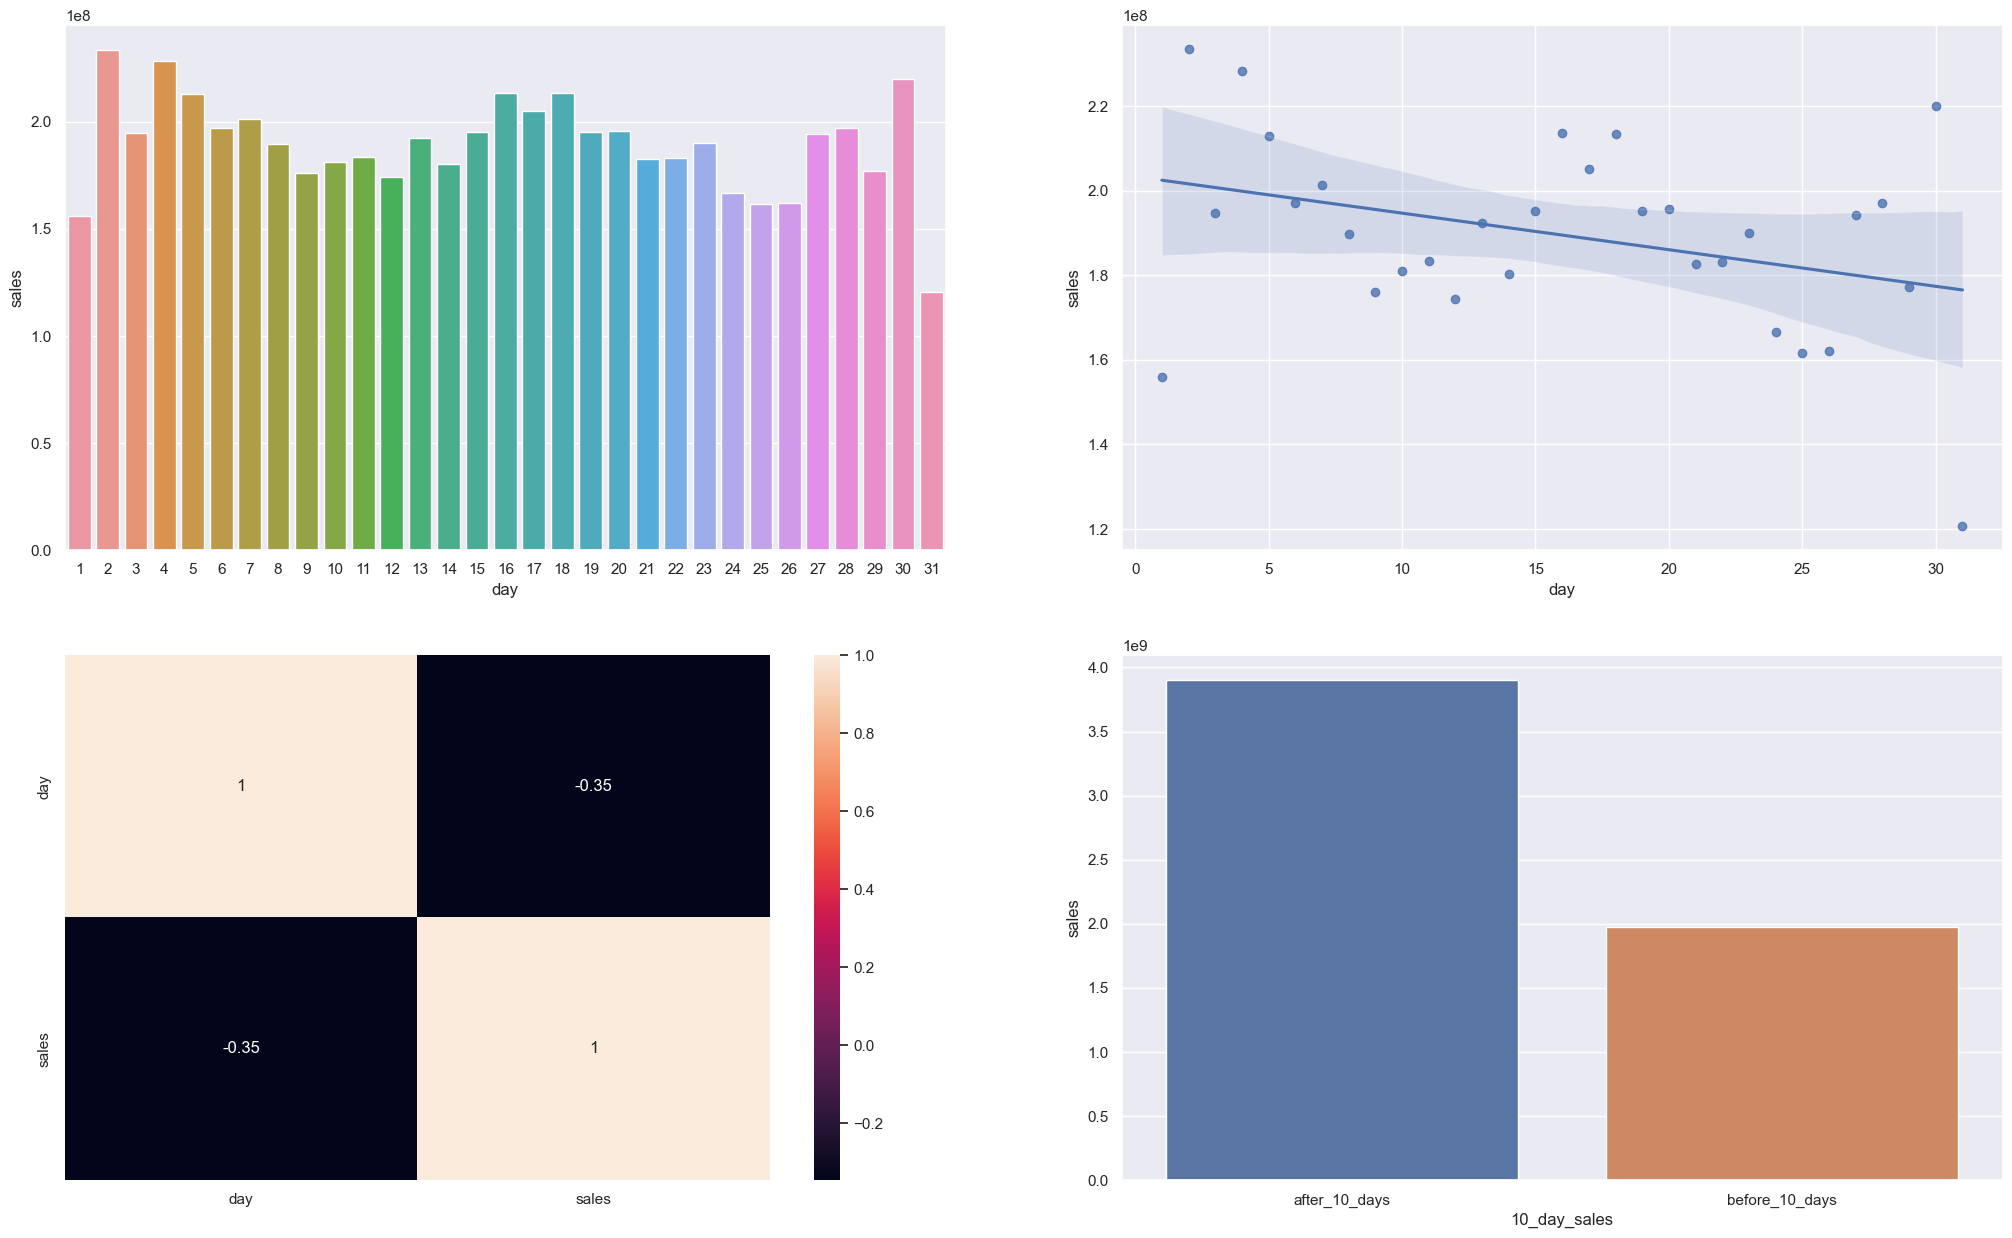

In [62]:
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()

plt.figure(figsize=(25,15))
plt.subplot(2,2,1)
sns.barplot(aux1, x='day', y='sales')

plt.subplot(2,2,2)
sns.regplot(aux1, x='day', y='sales')

plt.subplot(2,2,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

plt.subplot(2,2,4)
aux1['10_day_sales'] = aux1['day'].apply(lambda x: 'before_10_days' if x <=10 else 'after_10_days')
aux2 = aux1[['10_day_sales', 'sales']].groupby('10_day_sales').sum().reset_index()
sns.barplot(aux2, x='10_day_sales', y='sales');

#### **H11.** Lojas deveriam vender menos aos finais de semana.
**VERDADEIRO** Lojas vendem menos nos finais de semana 

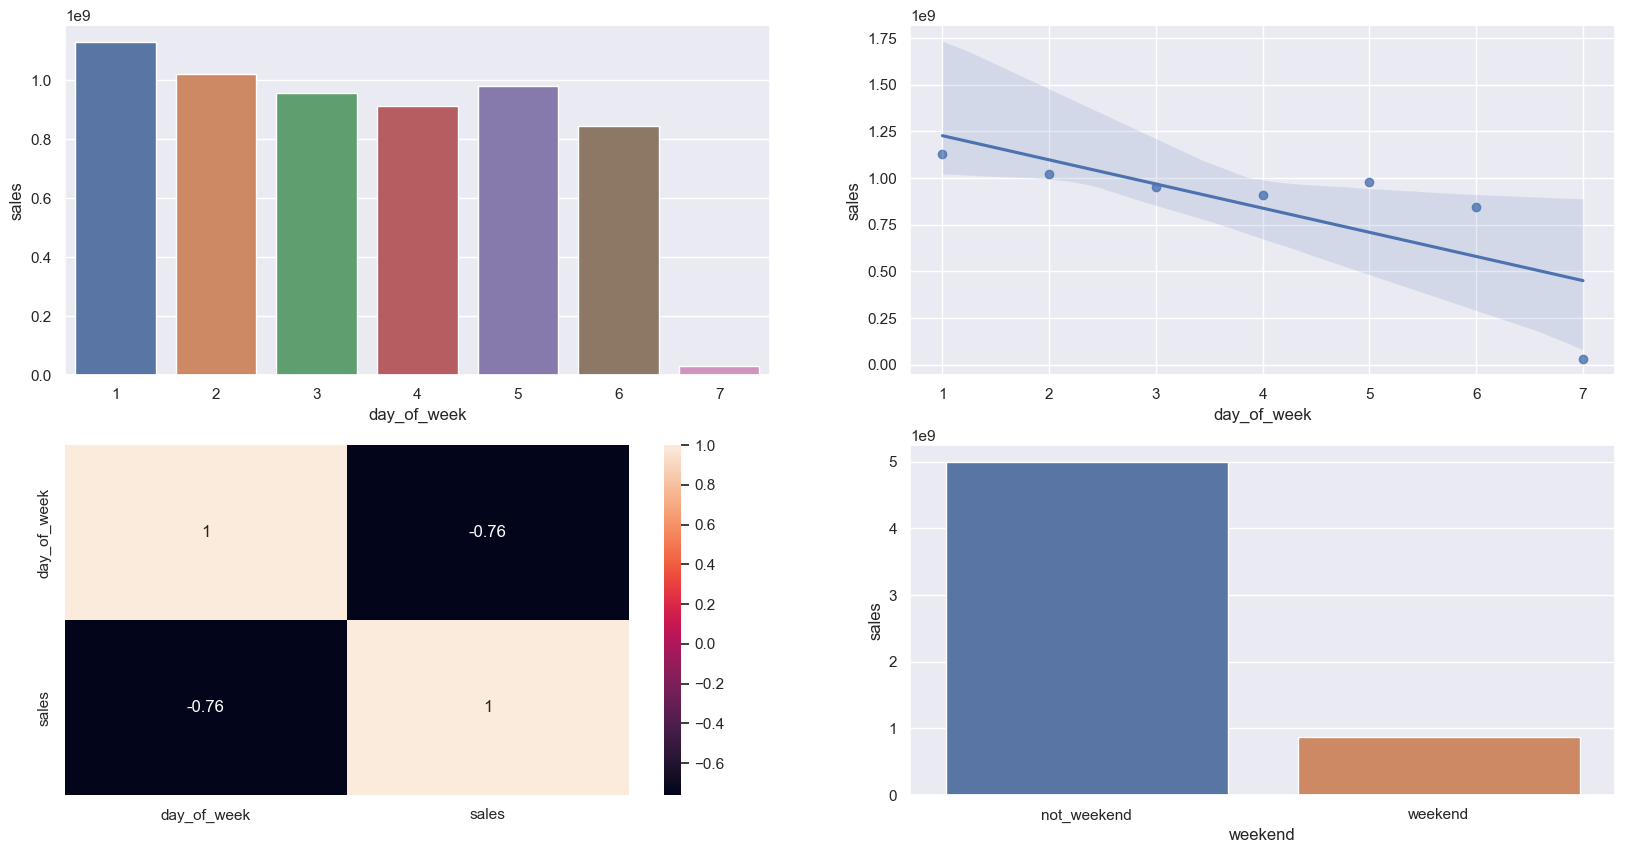

In [63]:
aux1 = df4[['day_of_week','sales']].groupby('day_of_week').sum().reset_index()

plt.figure(figsize=(20,10))
plt.subplot(2,2,1)
sns.barplot(aux1, x='day_of_week', y='sales')

plt.subplot(2,2,2)
sns.regplot(aux1, x='day_of_week', y='sales')

plt.subplot(2,2,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

aux1['weekend'] = aux1['day_of_week'].apply(lambda x: 'weekend' if ((x==6) | (x==7)) else 'not_weekend')
aux2 = aux1[['weekend', 'sales']].groupby('weekend').sum().reset_index()
plt.subplot(2,2,4)
sns.barplot(aux2, x='weekend', y='sales');

#### **H12.** Lojas deveriam vender menos durante os feriados escolares.
**VERDADEIRO** Lojas vendem menos durante os feriados escolares. No entanto, nos meses de Julho/Agosto (provavelmente ferias de verão), há uma inversão no comportamento

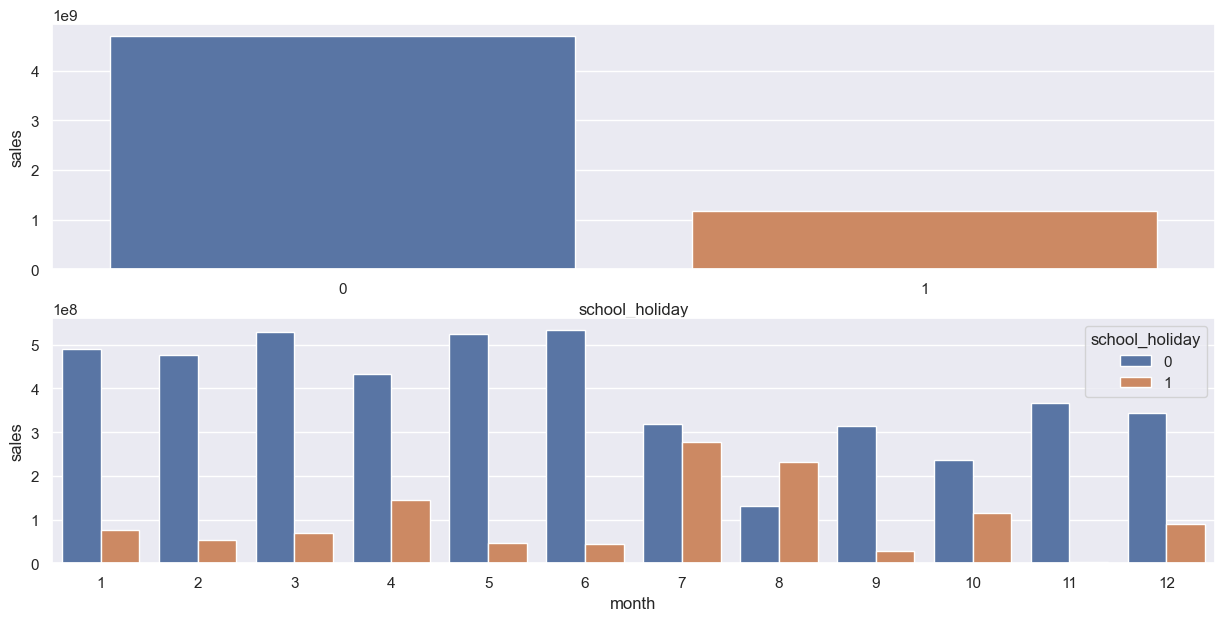

In [64]:
plt.figure(figsize=(15,7))

aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()
plt.subplot(2,1,1)
sns.barplot(aux1, x='school_holiday', y='sales')

aux2 = df4[['month', 'school_holiday', 'sales']].groupby(['month', 'school_holiday']).sum().reset_index()
plt.subplot(2,1,2)
sns.barplot(aux2, x='month', y='sales', hue='school_holiday');

### 4.2.2 Results Table

In [65]:
tab = [['Hipoteses', 'Conclusao', 'Relevancia'],
       ['H1', 'Falsa', 'Baixa'],
       ['H2', 'Falsa', 'Media'],
       ['H3', 'Falsa', 'Media'],
       ['H4', 'Falsa', 'Baixa'],
       ['H5', '-', '-'],
       ['H6', 'Falsa', 'Baixa'],
       ['H7', 'Falsa', 'Media'],
       ['H8', 'Falsa', 'Alta'],
       ['H9', 'Falsa', 'Alta'],
       ['H10', 'Verdadeira', 'Alta'],
       ['H11', 'Verdadeira', 'Alta'],
       ['H12', 'Verdadeira', 'Baixa'],
      ]
print( tabulate( tab, headers='firstrow' ) )

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Baixa
H5           -            -
H6           Falsa        Baixa
H7           Falsa        Media
H8           Falsa        Alta
H9           Falsa        Alta
H10          Verdadeira   Alta
H11          Verdadeira   Alta
H12          Verdadeira   Baixa


## 4.3 Multivariate Analysis

### 4.3.1 Numeric Attributes

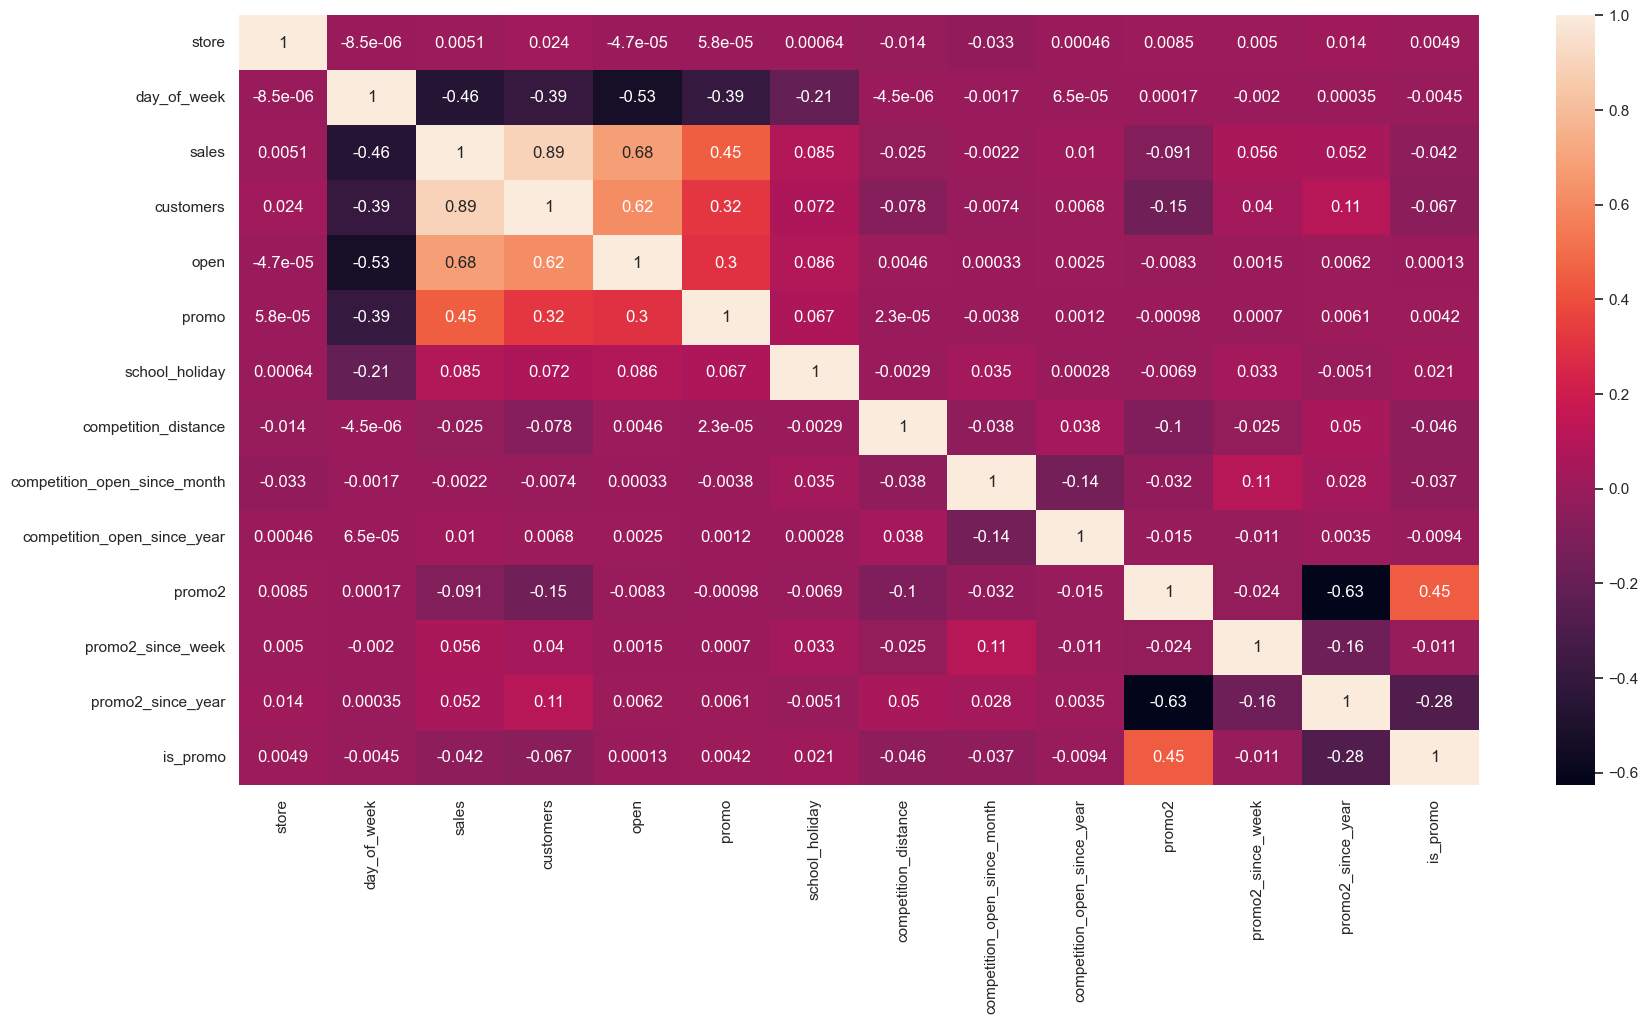

In [66]:
correlation = num_attributes.corr(method='pearson')
plt.figure(figsize=(20,10))
sns.heatmap(correlation, annot=True);

### 4.3.2 Categorical Attributes

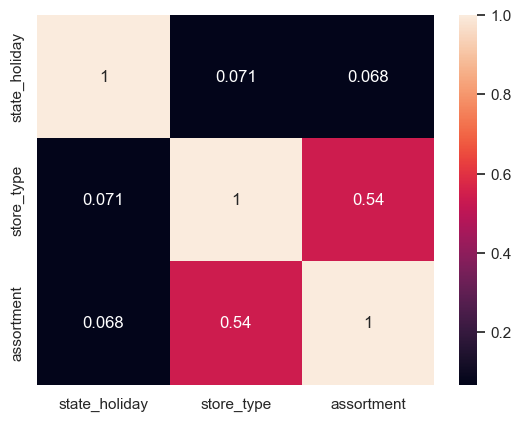

In [67]:
#Cramer's V - valores de 0 a 1 enquanto pearson vai de -1 a 1 - aplicar Bias correction

#selecting categorical data
categorical = df4.select_dtypes(include='object')

#calculating cramer's v
a1 = cramer_v(categorical['state_holiday'], categorical['state_holiday'])
a2 = cramer_v(categorical['state_holiday'], categorical['store_type'])
a3 = cramer_v(categorical['state_holiday'], categorical['assortment'])

a4 = cramer_v(categorical['store_type'], categorical['state_holiday'])
a5 = cramer_v(categorical['store_type'], categorical['store_type'])
a6 = cramer_v(categorical['store_type'], categorical['assortment'])

a7 = cramer_v(categorical['assortment'], categorical['state_holiday'])
a8 = cramer_v(categorical['assortment'], categorical['store_type'])
a9 = cramer_v(categorical['assortment'], categorical['assortment'])

d = pd.DataFrame({'state_holiday' : [a1,a2,a3],
                  'store_type' : [a4,a5,a6],
                  'assortment' : [a7,a8,a9] 
                })
d = d.set_index(d.columns)
sns.heatmap(d, annot=True);

# 5.0 Processing Data

In [68]:
df5 = df4.copy()

## 5.1 Normalizing 

In [69]:
#check section 4.1.2 for numeric variables that follow normal distribution (none of them).

## 5.2 Rescaling 

In [70]:
rs = RobustScaler()
mms = MinMaxScaler()

#competition distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values) #aplica a formula do robust scaler

#competition time month
df5['competition_time_months'] = rs.fit_transform(df5[['competition_time_months']].values)

#promo time week - não apresenta outliers relevantes
df5['promo_time_weeks'] = mms.fit_transform(df5[['promo_time_weeks']].values) #aplica o Min-Max Scaler

#year
df5['year'] = mms.fit_transform(df5[['year']].values)

## 5.3 Data Processing

### 5.3.1 Encoding categorical variables

In [71]:
#state_holiday - one hot encoding
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

#store_type - Label encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])

#assortment - Ordinal Encoding
assort = list(df5['assortment'].drop_duplicates())
assort[1], assort[2] = assort[2], assort[1]
assortment_dict = {assort[k]: k+1 for k in range(3)}
df5['assortment'] = df5['assortment'].map(assortment_dict)

### 5.3.2 Response Variable Distribution

In [72]:
df5['sales'] = np.log1p(df5['sales'])

<Axes: xlabel='sales', ylabel='Density'>

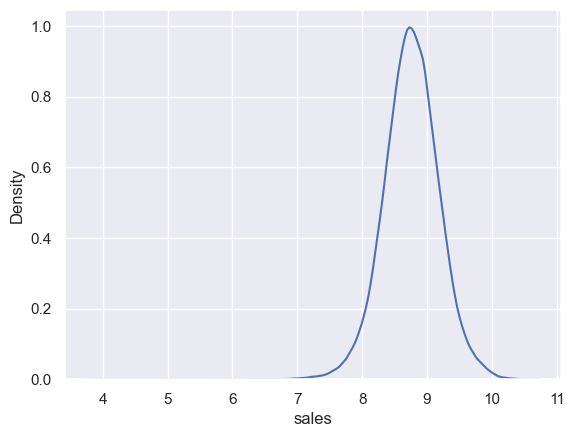

In [73]:
sns.kdeplot(df5['sales'])

### 5.3.2 Cyclical Feature Encoding

In [74]:
#day of week
df5['day_of_week_sin'] =  df5['day_of_week'].apply(lambda x: np.sin(x*(2*np.pi/7)))
df5['day_of_week_cos'] =  df5['day_of_week'].apply(lambda x: np.cos(x*(2*np.pi/7)))

#month
df5['month_sin'] =  df5['month'].apply(lambda x: np.sin(x*(2*np.pi/12)))
df5['month_cos'] =  df5['month'].apply(lambda x: np.cos(x*(2*np.pi/12)))

#day
df5['day_sin'] =  df5['day'].apply(lambda x: np.sin(x*(2*np.pi/30)))
df5['day_cos'] =  df5['day'].apply(lambda x: np.cos(x*(2*np.pi/30)))

#week of year
df5['week_sin'] =  df5['week'].apply(lambda x: np.sin(x*(2*np.pi/52)))
df5['week_cos'] =  df5['week'].apply(lambda x: np.cos(x*(2*np.pi/52)))

# 6.0 Feature Selection

In [75]:
df6 = df5.copy()

## 6.1 Spliting datafrage into training and test dataset

In [76]:
#como quero fazer a previsão de venda nas próximas 6 semanas, separarei as 6 últimas para teste
cols_drop = ['week', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']
df6 = df6.drop(cols_drop, axis=1)

In [77]:
df6[['store', 'date']].groupby('store').min().reset_index()

,store,date
0,1,2013-01-02
1,2,2013-01-02
2,3,2013-01-02
3,4,2013-01-02
4,5,2013-01-02
...,...,...
1110,1111,2013-01-02
1111,1112,2013-01-02
1112,1113,2013-01-02
1113,1114,2013-01-02


In [78]:
df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days=6*7)

Timestamp('2015-06-19 00:00:00')

In [79]:
#training dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales'] 

#test dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales'] 

print('Trainig Min Date: {}'.format( X_train['date'].min()))
print('Trainig Max Date: {}'.format( X_train['date'].max()))

print('\nTest Min Date: {}'.format( X_test['date'].min()))
print('Test Max Date: {}'.format( X_test['date'].max()))

Trainig Min Date: 2013-01-01 00:00:00
Trainig Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


## 6.2 Boruta as Feature Selector

#training and test dataset for Boruta
X_train_n = X_train.drop(['date', 'sales'], axis=1).values
y_train_n = y_train.values.ravel() #returns a numpy array

#defining RandomForestRegressor
rf = RandomForestRegressor(n_jobs=-1) #-1 uses all cores in parallel

#defining boruta
boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(x_train_n, y_train_n)

### 6.2.1 Best Features Boruta

#.support_ rankeia os attributos
cols_selected = boruta.support_.tolist()

#best features
X_train_fs = X_train.drop(['date', 'sales'], axis=1)
cols_selected_boruta = x_train_fs.iloc[:, cols_selected].columns.to_list()

#cols not selected boruta - np.setdiff1 retorna a diferença
cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta))

## 6.3 Manual Feature Selection

In [80]:
cols_not_selected_boruta = [
    'is_promo',
    'month_sin',
    'school_holiday',
    'state_holiday_christimas',
    'state_holiday_easter_holiday',
    'state_holiday_public_holiday',
    'state_holiday_regular_day',
    'week_sin',
    'year']

cols_selected_boruta = [
    'store',
    'promo',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'competition_time_months',
    'promo_time_weeks',
    'day_of_week_sin',
    'day_of_week_cos',
    'month_cos',
    'month_sin',
    'day_sin',
    'day_cos',
    'week_cos',
    'week_sin']

cols_selected_boruta_full = [
    'store',
    'promo',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'competition_time_months',
    'promo_time_weeks',
    'day_of_week_sin',
    'day_of_week_cos',
    'month_cos',
    'month_sin',
    'day_sin',
    'day_cos',
    'week_cos',
    'week_sin',
    'date',
    'sales']

In [81]:
#from section 4.2.2: H8 to H11 have high relevance
#H8 year are relevant - doesn't match boruta
#H9 months are relevant - matches boruta
#H10 days are relevant - matches boruta
#H11 day of week are relevant- matches boruta

# 7.0 Machine Learning Modelling

In [82]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

#time series
x_training = X_train[cols_selected_boruta_full]

## 7.1 Average Model

In [83]:
aux1 = X_test.copy()
aux1['sales']= y_test.copy()

#prediction
aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename(columns={'sales': 'predictions'})
aux1 = pd.merge(aux1, aux2, how='left', on='store')
yhat_baseline = aux1['predictions'] #estimativa

#performance
baseline_result = ml_error('Average Model', np.expm1(y_test), np.expm1(yhat_baseline)) #retorna os valores log para os originais
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.455051,1835.135542


## 7.2 Linear Regression Model

In [84]:
#model
lr = LinearRegression().fit(x_train, y_train)

#prediction
yhat_lr = lr.predict(x_test)

#performance
lr_result = ml_error('Linear Regressor', np.expm1(y_test), np.expm1(yhat_lr))
lr_result 
#erro do modelo de regressão linear é maior que o de média; modelo de média está eprformando melhor; os dados tem comportamento não linear

,Model Name,MAE,MAPE,RMSE
0,Linear Regressor,1867.089774,0.292694,2671.049215


### 7.2.1 Linear Regression Model - Cross Validation

In [85]:
lr_result_cv = cross_validation(x_training, 5, 'Linear Regression', lr, verbose=False)
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37


## 7.3 Linear Regression Regularized Model - Lasso

In [86]:
#model
lrr = Lasso(alpha=0.01).fit(x_train, y_train)

#prediction
yhat_lrr= lrr.predict(x_test)

#performance
lrr_result = ml_error('Linear Regressor - Lasso', np.expm1(y_test), np.expm1(yhat_lrr))
lrr_result 

,Model Name,MAE,MAPE,RMSE
0,Linear Regressor - Lasso,1891.704881,0.289106,2744.451737


### 7.3.1 Lasso - Cross Validation

In [87]:
lrr_result_cv = cross_validation(x_training, 5, 'Lasso', lrr, verbose=False)
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26


## 7.4 Random Forest Regressor

#model
rf = RandomForestRegressor(n_estimators=125, n_jobs=-1, random_state=42).fit(x_train, y_train)

#prediction
yhat_rf = rf.predict(x_test)

#performance
rf_result = ml_error('Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf))
rf_result                       

In [88]:
#resultado Random Forest Regressor
rf_result = pd.DataFrame({'Model Name': 'Random Forest Regressor',
                         'MAE': 677.912513,
                         'MAPE': 0.099699,
                         'RMSE': 1008.010268
                        }, index=[0])
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,677.912513,0.099699,1008.010268


In [89]:
from sklearnex import patch_sklearn
patch_sklearn()

from sklearn.ensemble import RandomForestRegressor

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [90]:
#model
rf = RandomForestRegressor(n_estimators=50, n_jobs=-1, random_state=42).fit(x_train, y_train)

#prediction
yhat_rf = rf.predict(x_test)

#performance
rf_result = ml_error('Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf))
rf_result                       

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,683.898891,0.100391,1028.048027


### 7.4.1 Random Forest Regressor - Corss Validation

In [91]:
rf_result_cv = cross_validation(x_training, 5, 'Random Forest Regressor', rf, verbose=True)
rf_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,866.42 +/- 235.6,0.12 +/- 0.03,1301.69 +/- 351.51


In [92]:
rf_result_cv = pd.DataFrame({'Model Name': 'Random Forest Regressor',
                         'MAE CV': '866.42 +/- 235.6',
                         'MAPE CV': '0.12 +/- 0.03',
                         'RMSE CV': '1301.69 +/- 351.51'
                        }, index=[0])
rf_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,866.42 +/- 235.6,0.12 +/- 0.03,1301.69 +/- 351.51


## 7.5 XGBoost Regressor

In [93]:
#model
model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
                             n_estimators=1000,
                             eta=0.01,
                             max_depth=10,
                             subsample=0.7,
                             colsample_bytree=0.9).fit(x_train, y_train)

#prediction
yhat_xgb = model_xgb.predict(x_test)

#performance
xgb_result = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb))
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,882.573655,0.128112,1299.083999


In [94]:
#resultado XGBoost
xgb_result = pd.DataFrame({'Model Name': 'XGBoost Regressor',
                         'MAE': 882.573655,
                         'MAPE': 0.128112,
                         'RMSE': 1299.083999
                        }, index=[0])
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,882.573655,0.128112,1299.083999


### 7.5.1 XGBoost Regressor - Cross Validation

In [95]:
xgb_result_cv = cross_validation(x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True)
xgb_result_cv


KFold Number: 5



KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,1044.72 +/- 158.4,0.14 +/- 0.01,1508.27 +/- 215.44


In [96]:
xgb_result_cv = pd.DataFrame({'Model Name': 'XGBoost Regressor',
                         'MAE CV': "1044.72 +/- 158.4",
                         'MAPE CV': "0.14 +/- 0.01",
                         'RMSE CV': '1508.27 +/- 215.44'
                        }, index=[0])
xgb_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,1044.72 +/- 158.4,0.14 +/- 0.01,1508.27 +/- 215.44


## 7.6 Comparing Model Performance

### 7.6.1 Performance kfold = 1

In [97]:
modelling_result = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result])
modelling_result.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,683.898891,0.100391,1028.048027
0,XGBoost Regressor,882.573655,0.128112,1299.083999
0,Average Model,1354.800353,0.455051,1835.135542
0,Linear Regressor,1867.089774,0.292694,2671.049215
0,Linear Regressor - Lasso,1891.704881,0.289106,2744.451737


### 7.6.2 Real Performance - Cross Validation

In [98]:
modelling_result_cv = pd.concat([lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv])
modelling_result_cv.sort_values('RMSE CV')

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,866.42 +/- 235.6,0.12 +/- 0.03,1301.69 +/- 351.51
0,XGBoost Regressor,1044.72 +/- 158.4,0.14 +/- 0.01,1508.27 +/- 215.44
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26
